In [1]:
import os
import sys
import re
import json
import time
import emoji
import random
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from copy import deepcopy
from datetime import date, datetime
from collections import Counter, OrderedDict

from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
# t0 = time.time()

In [2]:
cfg = dict()
cfg['input dir'] = 'input'

In [3]:
inFile = os.path.join(cfg['input dir'], 'Tweets_US.csv')
tweets_df = pd.read_csv(inFile, lineterminator='\n')
tweets_df.drop(columns=['user_verified', 'truncated', 'is_retweet', 'coordinates'], inplace=True, errors='ignore')
tweets_df['date'] = tweets_df['timestamp'].apply(lambda x: x[:x.find(' ')])

print(f'Number of tweets: {len(tweets_df) :,}')

Number of tweets: 621,404


In [4]:
tweets_df.head(20)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,timestamp,text,hashtags,retweet_count,favorite_count,has_media_type,in_reply_to_status_id,source,date
0,1322689760075436032,Mr LeJeune,NaN,"Humanity and facts rule, not fiction and fear",2016-06-27 21:20:03,30,95,225,2020-10-31 23:59:47,@WhiteHouse Biden will stand together with Europe against China. And make a better deal for all Americans.\n\n#Trump wanted the glory for himself and the licences for Ivanka. And made the farmers pay for his tarriffs.,['Trump'],0,0,NaN,1.322682e+18,Twitter for Android,2020-10-31
1,1322689749149167619,bourgeois francine,france,NaN,2013-04-05 16:06:05,407,1265,4702,2020-10-31 23:59:45,PUSSY cat ROAR #Trump #tartuffe @erictrump TERMINUS https://t.co/lukFfa7kQn,"['Trump', 'tartuffe']",0,0,NaN,NaN,Twitter Web App,2020-10-31
2,1322689740605255682,THCPetDoctor,"Berkeley, CA","I represent a group of 240+ veterinarians, MDs, and other doctors. We will flood Trump’s page with truth, facts, and science! Please help spread our message!",2016-10-03 04:16:44,89,179,105,2020-10-31 23:59:43,@realDonaldTrump Anti-Trump? PLEASE VOTE #MakeAmericaUnitedAgain #vetsforscience #FTrumpS #OperationMAGA #antitrump #dumptrump #biden2020 #trump #voteblue #negligenthomicide #blm #murdererinchief #bidenharris #shitler #FuckTrumpsShit https://t.co/tCqpXFdBJ7,"['MakeAmericaUnitedAgain', 'vetsforscience', 'FTrumpS', 'OperationMAGA', 'antitrump', 'dumptrump', 'biden2020', 'trump', 'voteblue', 'negligenthomicide', 'blm', 'murdererinchief', 'bidenharris', 'shitler', 'FuckTrumpsShit']",0,0,NaN,1.322688e+18,Twitter for iPhone,2020-10-31
3,1322689734255235077,The Hispanic Republican 🇺🇸,NaN,"I'm a Lawyer committed to protect freedom of speech, Follow for Conservative news without any kind of censorship, soon YOUTUBE PODCAST!\nHelp me out!\n🇺🇸",2020-10-15 04:24:37,2925,697,936,2020-10-31 23:59:41,"@JoeBiden You left a country ruined where half of the population was being called deplorables, you left an education system full of brainwashed hating Americans, using race as your card but forgetting about hispanic and black jobs, forget it we will not support you, we will vote #Trump",['Trump'],0,2,NaN,1.322689e+18,Twitter for Android,2020-10-31
4,1322689701199945728,EnigmaticallySimple,Inside Your Head,"I consider it #validation that #twitter has me #shadowbanned despite me not being offensive, followed by a lot of people, or inaccurate 👍@Twitter 🤡",2016-10-20 03:09:34,565,732,4208,2020-10-31 23:59:33,Says the chick from China. Of course you support #Biden https://t.co/63DCbreVCb,['Biden'],0,1,NaN,NaN,Twitter for Android,2020-10-31
5,1322689696195993600,Valery,NaN,well its down to less than 60 days..please vote the orange 🍊 monster 👹 out.,2020-03-27 01:05:59,2000,2140,1732,2020-10-31 23:59:32,Please don't unfollow me..I am loosing my mind just a tad before #ElectionDay ...I have been been against #Trump since before he was elected...3 more days..#USA don't let us down\n#VoteBlueToSaveAmerica #VoteBlueToEndTheNightmare,"['ElectionDay', 'Trump', 'USA', 'VoteBlueToSaveAmerica', 'VoteBlueToEndTheNightmare']",0,0,NaN,NaN,Twitter for Android,2020-10-31
6,1322689685034917892,Helmand,"California, USA","I am an independent thinker, I tweet what I think.",2014-07-23 01:48:43,840,185,837,2020-10-31 23:59:29,"Let's face it, Trump put the people of the United States in a situation that his winning and losing concerned everyone.#ElectionTwitter #Biden #Trump #Election2020","['ElectionTwitter', 'Biden', 'Trump', 'Election2020']",0,0,NaN,NaN,Twitter for iPhone,2020-10-31
7,1322689657277190144,Janet Werner,"Houston, TX","UH B.S. in Technology TRDE '90,\nUH M.S. in Technology OCTE '93,\nOLLU MBA '96 (emphasis in Strategic Planning)",2009-04-27 15:18:57,1449,1287,320327,2020-10-31 23:59:23,@TeaPainUSA @EmmaPeele3 and #Trump accomplished in 4 yrs what took Hitler a decade...to destroy a civilization.,['Trump'],1,0,NaN,1.322538e+18,Twitter Web App,2020-10-31


### Utility functions

In [5]:
def get_counter(X):
    """ Get counter and total for barplot
    """
    total = 0
    counter = Counter()
    for values in X:
        for x in values:
            counter[x] += 1
            total += 1

    counter = OrderedDict(counter.most_common())
    return counter, total
   
def get_df_plot(counter, col_name='values'):
    Y, ct = [], []
    for k,v in counter.items():
        Y.append(k)
        ct.append(v)

    df = pd.DataFrame()
    df[col_name] = Y
    df['count']  = ct
    
    return df

def custom_barplot(df, top, x_label='values'):    
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))
    sns.barplot(x=x_label, y='count', data=df[:top], ax=ax1)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{x_label} Count'.title())

    plt.xticks( rotation=45, horizontalalignment='right', fontsize='x-large')
    plt.show()

### EDA

#### Tweet daily Count

In [6]:
tmp_df = pd.DataFrame()
tmp_df['date'] = tweets_df['date']
tmp_df['time'] = tweets_df['timestamp'].apply(lambda x: x[x.find(' ')+1:])
tmp_df['hrs']  = tmp_df['time'].apply(lambda x: x[:2])
tmp_df['date_hrs'] = tmp_df['date'] + '_' + tmp_df['hrs']

<AxesSubplot:title={'center':'Tweet Count by Date'}, xlabel='date'>

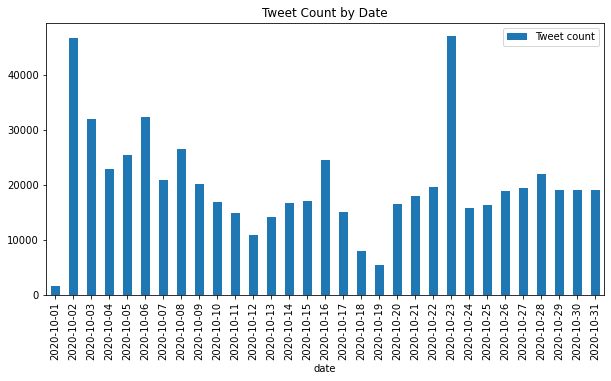

In [7]:
tmp = tmp_df[['date','time']].groupby(['date']).count()
tmp.rename(columns={'time':'Tweet count'}, inplace=True)
tmp.plot.bar(title='Tweet Count by Date', figsize=(10,5))

<AxesSubplot:title={'center':'Mean Tweet Counts by Hours (UTC)'}, xlabel='hrs'>

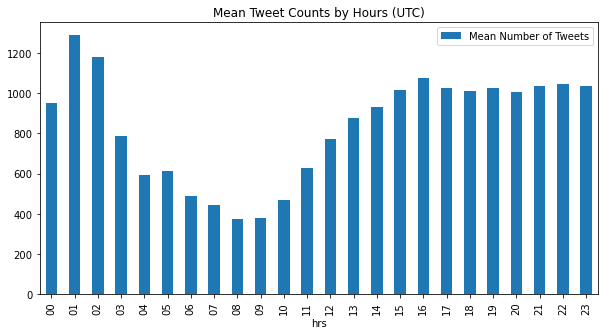

In [8]:
tmp = tmp_df[['hrs','time']].groupby(['hrs']).count()
tmp.rename(columns={'time':'Mean Number of Tweets'}, inplace=True)
tmp['Mean Number of Tweets'] = tmp['Mean Number of Tweets']/len(np.unique(tmp_df.date.values))

tmp.plot.bar(title='Mean Tweet Counts by Hours (UTC)', figsize=(10,5))

/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


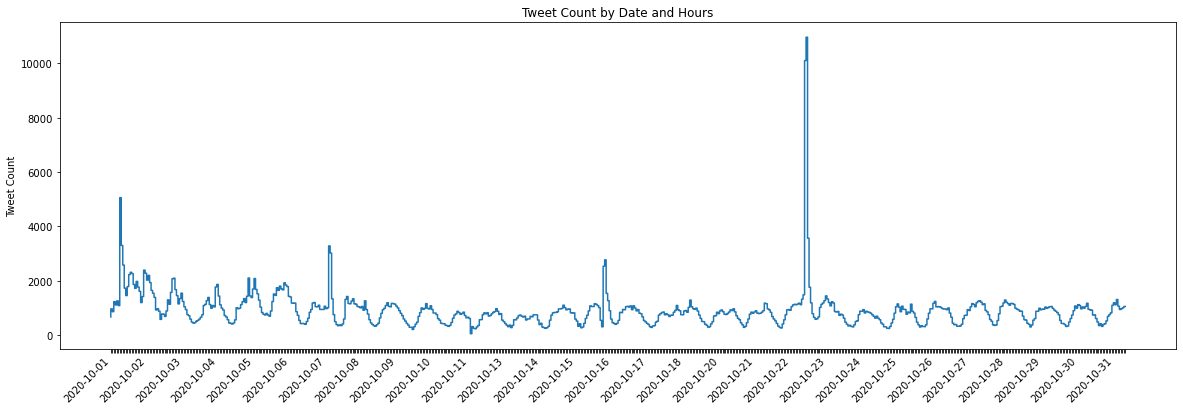

In [9]:
tmp = tmp_df[['date_hrs','time']].groupby(['date_hrs']).count()
tmp.rename(columns={'time':'Tweet count'}, inplace=True)
tmp['date'] = tmp.index
tmp['date'] = tmp['date'].apply(lambda x: x[:x.find('_')])

fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))
ax1.step(tmp.index, tmp['Tweet count'])
ax1.set_ylabel('Tweet Count')
ax1.set_title('Tweet Count by Date and Hours')
ax1.set_xticklabels(tmp['date'], rotation=45, ha='right')

every_nth = 24
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

#### Hashtag distribution (static and time-series)

In [47]:
hashtagsCount = Counter()
for hashtags in tweets_df.hashtags.values:
    for hashtag in eval(hashtags):        
        hashtagsCount[hashtag.lower()] += 1

hashtagsCount = OrderedDict(hashtagsCount.most_common())

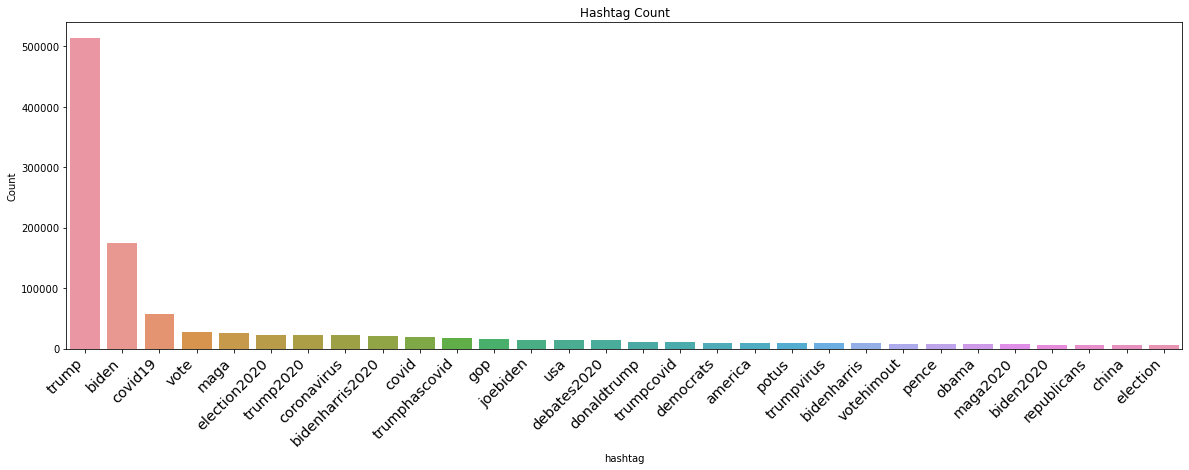

In [49]:
df = get_df_plot(hashtagsCount, 'hashtag')
custom_barplot(df, top=30, x_label='hashtag')

In [50]:
df[:100]

,hashtag,count
0,trump,513994
1,biden,174820
2,covid19,56719
3,vote,27800
4,maga,25224
5,election2020,23245
6,trump2020,23200
7,coronavirus,21925
8,bidenharris2020,20842
9,covid,19104


#### Data preparation for Race Bar chart

In [43]:
%%time

hashtagsCount = Counter()
for hashtags, date in tweets_df[['hashtags', 'date']].values:
    for hashtag in eval(hashtags):
        hashtagsCount[(hashtag.lower(), date)] += 1

tmp = dict()
for k, v in hashtagsCount.items():
    if v > 100:
        tmp[k] = [v]

hashtag_by_date = pd.DataFrame(tmp)
hashtag_by_date = hashtag_by_date.transpose()
hashtag_by_date = hashtag_by_date.unstack(-1)
hashtag_by_date.columns = hashtag_by_date.columns.droplevel()
hashtag_by_date.fillna(0, inplace=True)
hashtag_by_date.reset_index(inplace=True)
hashtag_by_date.to_csv('US_election_hashtag_race_barchart_data.csv', index=False)

CPU times: user 11 s, sys: 11.9 ms, total: 11 s
Wall time: 11 s


#### Location

In [13]:
places_df = pd.read_csv(os.path.join(cfg['input dir'], 'City_Country.csv'))
places_df = places_df.applymap(lambda x: str(x).lower())

print(f"places_df has {len(places_df) :,} entries")
places_df.head()

places_df has 23,018 entries


,city,country,subcountry,geonameid
0,les escaldes,andorra,escaldes-engordany,3040051
1,andorra la vella,andorra,andorra la vella,3041563
2,umm al qaywayn,united arab emirates,umm al qaywayn,290594
3,ras al-khaimah,united arab emirates,raê¼s al khaymah,291074
4,khawr fakkän,united arab emirates,ash shäriqah,291696


In [14]:
states_df = pd.read_csv(os.path.join(cfg['input dir'], 'USA_States_code.csv'))
states_df.head()

,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [15]:
countries = set(places_df.country.unique())
print(f"countries has {len(countries) :,} entries")

countries has 244 entries


In [16]:
city_to_subcountry = places_df[['city','subcountry']].set_index('city').T.to_dict('records')
city_to_subcountry = city_to_subcountry[0]

/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [17]:
city_to_country = places_df[['city','country']].set_index('city').T.to_dict('records')
city_to_country = city_to_country[0]

#Append special cases:
additonals = {
    'uk' : 'united kingdom',
    'us' : 'united states',
    'usa': 'united states',
    '美國': 'united states',
    '香港': 'hong kong',
    '日本': 'japan',
    '東京': 'japan',
    '台灣': 'taiwan',
    '台北': 'taiwan',
    '北京': 'china',
    '上海': 'china',
    '中华人民共和国': 'china'
}

city_to_country.update(additonals)
print(f"city_to_country has {len(city_to_country) :,} entries")

/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


city_to_country has 21,952 entries


In [18]:
subcountry_to_country = places_df[['subcountry', 'country']].set_index('subcountry').T.to_dict('records')
subcountry_to_country = subcountry_to_country[0]
print(f"subcountry_to_country has {len(subcountry_to_country) :,} entries")

/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


subcountry_to_country has 2,592 entries


In [19]:
def find_countries(text):            
    #------------------------------------#
    def lookup(term):        
        if term in countries:
            return term
        elif term in city_to_country:            
            return city_to_country[term]
        elif term in subcountry_to_country:
            return subcountry_to_country[term]
        else:
            return ''
    #------------------------------------#
    
    Y = set()
    terms = text.split()
        
    if len(text) == 0:
        return Y
    
    elif len(terms) == 1:
        result = lookup(terms[0])
        if len(result) > 0:
            Y.add(result)                          
    else:   
        check_single_term = True  
        
        for t1, t2 in zip(terms[:-1], terms[1:]):                      
            result = lookup(f'{t1} {t2}')            
            if len(result) > 0:
                Y.add(result)
                check_single_term = False        
                
            elif check_single_term:
                result = lookup(t1)
                if len(result) > 0:
                    Y.add(result)
                    
            else:
                check_single_term = True
          
        if check_single_term:
            result = lookup(terms[-1])
            if len(result) > 0:
                Y.add(result)    

    return Y 
        

In [20]:
%%time
pandarallel.initialize()

def clean(text):
    text = emoji.demojize(text)    
    text = re.sub(r'([^\w]|\_)', ' ', text) 
    return " ".join(text.lower().split())

#--------------------------------------------#
df = tweets_df[tweets_df.user_location.notna()]
df['user_location'] = df['user_location'].parallel_apply(lambda x: clean(x))
df['countries'] = df['user_location'].parallel_apply(lambda x: find_countries(x))

user_location_count, total = get_counter(df.countries.values)
print(f"Total count: {total :,}")

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Total count: 383,889
CPU times: user 2.34 s, sys: 560 ms, total: 2.91 s
Wall time: 13.6 s


/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


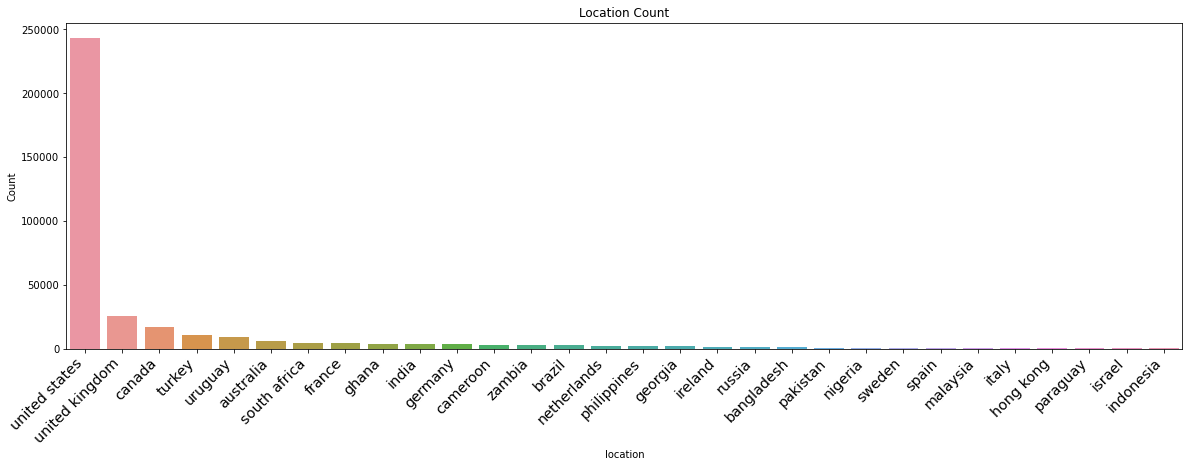

In [21]:
df_loc_count = get_df_plot(user_location_count, 'location')
custom_barplot(df_loc_count, top=30, x_label='location')

In [22]:
#Print out for checking:
for text in np.unique(tweets_df[tweets_df.user_location.notna()]['user_location'].values):
    print(text, '$#$', find_countries(clean(text)))

	 San Francisco, CA $#$ {'united states'}
	USA $#$ {'united states'}

 $#$ set()

#NSA
 $#$ set()

U. S. A $#$ set()
  $#$ set()
     $#$ set()
       $#$ set()
           $#$ set()
                   $#$ set()
                    USA $#$ {'united states'}
                 Washington DC $#$ {'united states'}
      Earth  $#$ set()
     Cathlamet, Wa. $#$ {'ghana'}
   WorldWide $#$ set()
  AbsoBLUEtly #VoteBlue $#$ set()
  Drammen, rett ved polet $#$ {'norway'}
  Europe $#$ set()
  FL, Mass, New Hampshire $#$ {'united states'}
  Florida $#$ {'uruguay'}
  Karachi pakistan $#$ {'pakistan'}
  Lampe diya $#$ set()
  MA $#$ set()
  Manhattan, by way of DUVAL $#$ {'united states', 'turkey'}
  NC $#$ set()
  NYC ✈️ Miami $#$ {'united states'}
  Shropshire England  $#$ {'united kingdom'}
  UK $#$ {'united kingdom'}
  USA & Italy 🧡  👉#MarEthr $#$ {'italy', 'united states'}
  bottom of school hierarchy $#$ {'turkey'}
  suspendeme esta  $#$ set()
  🎭 $#$ set()
 "India The Bharat"  $#$ {'india'}
 #

#LosAngeles $#$ set()
#MAGA $#$ set()
#MAGA #ClickyBuzz🐝#ClickyClubs $#$ set()
#MAGA #KAG2020 #FourMoreYears  $#$ set()
#MAGA #TCOT #NRA SoCalHD $#$ set()
#MAGA Country $#$ set()
#MAGAFORNIA! $#$ set()
#MUC, Temporary, #US #Boston $#$ {'united states'}
#Manchester $#$ {'united states'}
#MedicareForAll USA $#$ {'united states'}
#Merica $#$ set()
#MichiganStrong $#$ set()
#Montreal $#$ set()
#Morocco #Canada #USA $#$ {'canada', 'united states', 'morocco'}
#MountainMan $#$ set()
#Mozarmy $#$ set()
#Mpls, USA $#$ {'united states'}
#MusicVideoTimeWarp $#$ set()
#Muskoka $#$ set()
#NC, #DC, #NYC, #UK $#$ {'united kingdom'}
#NJ7 Branchburg, NJ $#$ set()
#NY #AMD #GZP #VNS  $#$ set()
#NY21 $#$ set()
#NYC $#$ set()
#NYC and Around-The-World $#$ set()
#NYC and Beyond $#$ set()
#NeverBernie Seriously, Never $#$ set()
#New York #USA $#$ {'united states'}
#Newbury $#$ {'united kingdom'}
#Newcastle Upon Tyne, England $#$ {'united kingdom', 'south africa'}
#NewportNoir $#$ set()
#No EXP👇NEC👇 #GetTheA

1060 W Addison Chicago, IL $#$ {'united states'}
1060 W Addsion St Chicago IL $#$ {'united states'}
10601 $#$ set()
10pm to 1am $#$ set()
110 9th Ave SW, Calgary, AB T2P 0T1, Canada, Alberta $#$ {'canada'}
111 S Market St. Benson, NC  $#$ set()
113 BUZZARDS CIRCLIN YOCARCUS  $#$ set()
11550 $#$ set()
1178-Broadway, NY, NY 10001 $#$ set()
11784 $#$ set()
11° 19' 0 N , 142° 15' 0 E $#$ set()
12 odeyemi str oluwo abeokuta $#$ {'nigeria'}
12.9141° N, 74.8560° E $#$ set()
120, udyog bhavan, sonawal road , goregaon East, Mumbai 400063, India $#$ {'cameroon', 'india'}
12084 $#$ set()
1209 E. Belknap, Fort Worth, Texas 76102 $#$ {'united states'}
123 Fuckyou Dr N. Philly USA $#$ {'united states'}
123 fake street $#$ set()
1230-uttara, Dhaka, Bangladesh $#$ {'bangladesh'}
1232 22nd St NW $#$ set()
127.0. 0.1 $#$ set()
127.0.0.1 $#$ set()
129 W. 81st Street NY, Apt. 5A $#$ set()
12th and Penn NW Washington DC $#$ {'united states'}
12°18'03.7"S 168°48'54.4"E $#$ set()
13 mi. from your location. $

@PureMichigan - USA $#$ {'united states'}
@SAITAMA/JAPAN $#$ {'japan'}
@TheLastAngryMale on Parler! $#$ set()
@TheMcClaneApocalypse $#$ set()
@UCSDMedSchool she/her🇨🇦🇺🇸 $#$ {'canada', 'united states'}
@WolfPacHQ $#$ set()
@btsongs_twt/@songstruggletwt $#$ set()
@budneeb $#$ set()
@cecilcharles on Parler $#$ set()
@conormmcauley $#$ set()
@darintino_ig $#$ set()
@deccanherald @Mysore $#$ {'india'}
@dontboreus on insta 📷 $#$ set()
@edisidigital @KLShopee  $#$ set()
@glen20shuffler $#$ set()
@gordon ramsay  $#$ set()
@home $#$ set()
@home...There's this pandemic. $#$ set()
@illinois1122 $#$ set()
@judgesmailstheking on Parler $#$ set()
@moderndaysplinteredpangea $#$ set()
@mundus $#$ set()
@nakwrdfairytale @fisajanedoe $#$ set()
@realdonaldtrump’s #1 fan $#$ set()
@rugbywc2019  $#$ set()
@stephens_pt $#$ set()
@the Crossroads of East & West $#$ {'cameroon', 'turkey'}
@toponepen $#$ set()
@trevorsmithfnp (healthtweets) $#$ set()
@twitter $#$ set()
A "Capitalist Shithole" $#$ set()
A 5 min.

Akwa Ibom State, Nigeria $#$ {'nigeria'}
Akwa lbom State $#$ set()
Akwesasne, NY  $#$ set()
Al Hilal - C Ring Road $#$ set()
Al Khobar $#$ {'saudi arabia'}
Al Khobar, Kingdom of Saudi Arabia $#$ {'saudi arabia', 'turkey'}
Al Khobar, Saudi Arabia $#$ {'saudi arabia'}
Al Madinah Al Munawwarah, King $#$ set()
Al Mansouriyah, Kuwait $#$ {'kuwait'}
Al Wakra, Qatar $#$ {'qatar'}
Al ain & ABU Dhabi $#$ {'united arab emirates'}
Al final del arcoiris xD $#$ set()
Al-Khobar, Ash Sharqiyah KSA $#$ {'saudi arabia'}
Al-Maghreb Al-Aqsa $#$ set()
Alabama $#$ {'united states'}
Alabama  $#$ {'united states'}
Alabama Gulf Coast $#$ {'united states'}
Alabama USA $#$ {'united states'}
Alabama | Everywhere $#$ {'united states'}
Alabama 🐢 $#$ {'united states'}
Alabama, Birmingham $#$ {'united states'}
Alabama, USA $#$ {'united states'}
Alabama, United States $#$ {'united states'}
Alabama.US $#$ {'united states'}
Alabamastan $#$ set()
Alabaster, Alabama $#$ {'united states'}
Alamala, Nigeria $#$ {'nigeria'}


Aquí y allá $#$ set()
Aquí🌎pero de Acá🌥️ $#$ set()
Arab Levant $#$ set()
Arab World $#$ set()
Arab world where the heart is $#$ set()
Arabian Gulf $#$ set()
Arbeidsutvalget i Bergen Høyre $#$ {'norway'}
Arcade, NY Bills Country $#$ set()
Arcadia (Los Angeles suburb) $#$ {'united states'}
Arcadia, CA $#$ {'united states'}
Arcata, CA $#$ {'united states'}
Arctic Bay, Nunavut $#$ {'philippines'}
Arden Hills, Minnesota $#$ {'united states'}
Arden on the Severn, MD $#$ {'united states'}
Ardmore, PA $#$ {'united states'}
Area 51 $#$ set()
Area 52 🖖 $#$ {'romania'}
Area 52; Ship repairs... $#$ set()
Arecibo, Puerto Rico $#$ {'puerto rico'}
Arena $#$ set()
Arendal/Norway $#$ {'norway'}
Arendelle $#$ set()
Arequipa, Peru $#$ {'peru'}
Arewa,Nigeria $#$ {'nigeria'}
Argentina $#$ {'argentina'}
Argentina & The Cloud $#$ {'argentina'}
Argentina / Italia $#$ {'argentina'}
Argentum $#$ set()
Argo, AL $#$ set()
Argyll SCO et Noyers FR $#$ set()
Arhus, Denmark $#$ {'denmark'}
Ariana🙈 $#$ {'tunisia'}
Ari

BGC $#$ set()
BH / VV  $#$ set()
BHARAT $#$ set()
BHD-MAN-BOS-DUB-PBI-GLA $#$ {'ivory coast'}
BHM $#$ set()
BHU VAIKUNTH $#$ set()
BIAFRA $#$ set()
BIAFRA LAND $#$ set()
BIAFRA NATION♀️🇱🇷🇮🇱 $#$ {'liberia', 'israel'}
BIDEN OR PUTIN, CHOOSE! #VOTE $#$ set()
BIDEN/HARRIS COUNTRY, USA $#$ {'united states'}
BIG BLUE NATION! $#$ set()
BILL SHORTEN 4 PM $#$ set()
BIR TAWIL $#$ set()
BIRMINGHAM ENGLAND $#$ {'united kingdom', 'united states'}
BIRMINGHAM, UK $#$ {'united kingdom', 'united states'}
BITCH I'M FROM LOUISIANA $#$ {'united states'}
BK (via Amherst/Boston) $#$ {'united states'}
BK ALL DAY... $#$ set()
BK NY $#$ set()
BK all day!!! $#$ set()
BK, NY $#$ set()
BK/CLT $#$ set()
BKK $#$ set()
BKNYATX $#$ set()
BK✈MIA✈NYC $#$ set()
BL9 $#$ set()
BLACK CONTINENT, AFRICA $#$ set()
BLACK EXCELLENCE $#$ set()
BLACKPINK in your area $#$ set()
BLM $#$ set()
BLM  $#$ set()
BLM AVE $#$ set()
BLM Blvd $#$ set()
BLM/VOTE $#$ set()
BLN | derzeit Brandenburg $#$ {'germany'}
BLOCKCHAIN $#$ set()
BLR $#$

Beaumont, CA $#$ {'united states'}
Beaumont, TX $#$ {'united states'}
Beaumont, TX Baton Rouge, LA $#$ {'united states'}
Beaumont,CA $#$ {'united states'}
Beautiful Appalachia $#$ set()
Beautiful B.C. $#$ set()
Beautiful Bay Area California $#$ {'united states', 'philippines'}
Beautiful Blue Colorado  $#$ {'brazil'}
Beautiful British Columbia $#$ {'canada'}
Beautiful British Columbia  $#$ {'canada'}
Beautiful British Columbia, Canada $#$ {'canada'}
Beautiful British Columbia🗻 $#$ {'canada', 'japan'}
Beautiful Burgh! $#$ set()
Beautiful California.  $#$ {'united states'}
Beautiful Canada 🇨🇦  $#$ {'canada'}
Beautiful Central Coast Cali $#$ {'colombia', 'united states'}
Beautiful Central New York $#$ {'united states'}
Beautiful Colorado $#$ {'brazil'}
Beautiful Eastern Frisia $#$ {'zambia'}
Beautiful Green Mountain State $#$ {'united states'}
Beautiful Montana $#$ {'bulgaria'}
Beautiful NC $#$ set()
Beautiful New England  $#$ {'united kingdom'}
Beautiful Northern Michigan $#$ {'united sta

Beverly Hills, CA  $#$ {'united states'}
Beverly Hills, CA   Aspen, CO  $#$ {'united states'}
Beverly Hills, CA. $#$ {'united states'}
Beverly Hills, Ca. $#$ {'united states'}
Beverly Hills, California $#$ {'united states'}
Beverly Hills, California  $#$ {'united states'}
Beverly Hills, FL $#$ {'united states'}
Beverly Hills, MI $#$ {'united states'}
Beverly Hills,CA $#$ {'united states'}
Beverly Hills/ Milano $#$ {'italy', 'united states'}
Beverly Hills/ Palm Springs $#$ {'united states'}
Beverly Hills/Paris, France $#$ {'united states', 'france'}
Beverly, MA $#$ {'united states'}
BeverlyHills $#$ set()
Bexhill $#$ set()
Bexley, London $#$ {'united kingdom'}
Beyond Earth...Hawaii 4 winter $#$ {'united states'}
Beyond The M25, UK $#$ {'united kingdom'}
Beyond The Mysterious Beyond  $#$ set()
Beyond The Yellow Brick Road $#$ set()
Beyond the Doctrinal Framework $#$ set()
Beyond the State $#$ set()
Beyond the Sun $#$ set()
Beyond the barricade. $#$ set()
Beyond the wall $#$ set()
Beyond 

Brighton&Hove $#$ {'united states'}
Brighton, East Sussex BN1 8AS $#$ {'australia'}
Brighton, England $#$ {'united kingdom', 'united states'}
Brighton, London, World. $#$ {'united kingdom', 'united states'}
Brighton, MI $#$ {'united states'}
Brighton, Madrid, Slack $#$ {'united states', 'spain'}
Brighton, NY $#$ {'united states'}
Brighton, U.K $#$ {'united states'}
Brighton, UK $#$ {'united kingdom', 'united states'}
Brighton, well Hove, actually $#$ {'united states'}
Brighton,CO $#$ {'united states'}
Brighton.  $#$ {'united states'}
Brighton. Michigan $#$ {'united states'}
Brighton...somewhere. $#$ {'united states'}
Brighton/Windsor, Earth $#$ {'united states'}
Brillion, WI $#$ set()
Brimfield, Illinois, USA $#$ {'united states'}
Bris Vegas Baby!!! $#$ set()
Brisbane $#$ {'australia'}
Brisbane  Australia $#$ {'australia'}
Brisbane / Rutland $#$ {'united states', 'australia'}
Brisbane Australia $#$ {'australia'}
Brisbane Australia  $#$ {'australia'}
Brisbane City, Brisbane $#$ {'austra

Calgary, AB Canada $#$ {'canada'}
Calgary, Ab $#$ {'canada'}
Calgary, Alberta $#$ {'canada'}
Calgary, Alberta  $#$ {'canada'}
Calgary, Alberta, Canada $#$ {'canada'}
Calgary, Alberta. $#$ {'canada'}
Calgary, Alberta. Canada $#$ {'canada'}
Calgary, Canada $#$ {'canada'}
Calgary, Canada / Treaty 7  $#$ {'canada'}
Calgary,Alberta $#$ {'canada'}
Calgary,Canada $#$ {'canada'}
Calgary/ Los Angeles $#$ {'canada', 'united states'}
Cali $#$ {'colombia'}
Cali  $#$ {'colombia'}
Cali Native $#$ {'colombia'}
Cali Raised but lives in Tx $#$ {'colombia'}
Cali Vegas $#$ {'colombia'}
Cali baby $#$ {'colombia'}
Cali colombia $#$ {'colombia'}
Cali for life.  $#$ {'colombia'}
Cali london bangkok $#$ {'united kingdom', 'colombia', 'thailand'}
Cali, Colombia $#$ {'colombia'}
Cali/ATL $#$ {'colombia'}
CaliFloGa, USA $#$ {'united states'}
Calibaby  $#$ set()
Calicut $#$ set()
Calicut, Kerala $#$ {'india'}
Calif $#$ set()
Calif. Native, Colorado Now - Heaven Bound $#$ {'brazil'}
Calif., Idaho, Ore. and Wash. $

Center of the Universe $#$ {'turkey'}
Center of the Universe ABQ, NM $#$ {'turkey'}
Centered $#$ set()
Centerville IN $#$ {'united states'}
Centerville, IA $#$ {'united states'}
Centerville, UT $#$ {'united states'}
Centerville,Tn $#$ {'united states'}
Central #Thighland $#$ {'united states'}
Central Africa Republic  $#$ {'united states'}
Central African Republic $#$ {'united states'}
Central Alabama, USA $#$ {'united states'}
Central Alberta $#$ {'canada', 'united states'}
Central America  $#$ {'united states'}
Central Cali $#$ {'colombia', 'united states'}
Central California $#$ {'united states'}
Central California  $#$ {'united states'}
Central California   $#$ {'united states'}
Central California Foothills $#$ {'united states'}
Central Canada $#$ {'canada', 'united states'}
Central Canada  $#$ {'canada', 'united states'}
Central City, KY $#$ {'united states'}
Central City, NE $#$ {'united states'}
Central Coast $#$ {'united states'}
Central Coast - Northern Calif $#$ {'united state

Chicagoland $#$ set()
Chicagoland  $#$ set()
Chicagoland / NW Indiana $#$ {'united states'}
Chicagoland Illinois $#$ {'united states'}
Chicagoland USA $#$ {'united states'}
Chicagoland and SW Michigan $#$ {'united states'}
Chicagoland area $#$ set()
Chicagoland, IL $#$ set()
Chicagoland, Illinois $#$ {'united states'}
Chicagou $#$ set()
Chicago—land  $#$ {'united states'}
Chicago➡️Reno➡️GLC, WI $#$ {'united states'}
Chichester $#$ {'united kingdom'}
Chichester and London $#$ {'united kingdom'}
Chichester, England $#$ {'united kingdom'}
Chichester, West Sussex $#$ {'united kingdom', 'cameroon'}
Chickamauga, GA $#$ set()
Chickamauga, ga $#$ set()
Chicken Bristle Kentucky $#$ {'united states'}
Chickie. $#$ set()
Chico $#$ {'united states'}
Chico, CA $#$ {'united states'}
Chicopee, MA $#$ {'united states'}
Chicopee, ma $#$ {'united states'}
Chicopee,Ma $#$ {'united states'}
Chidlow, Western Australia $#$ {'australia'}
Chief Exec of #SIN,R'kaneville $#$ {'turkey'}
Chief Market Punk $#$ set(

Cord Cutting University $#$ {'united states'}
Cordele, GA $#$ set()
Cordova, TN $#$ {'philippines'}
Corfton Bache  $#$ set()
Coring out the Apple. $#$ set()
Corinth, MS $#$ {'united states'}
Corinth, TX $#$ {'united states'}
Cork $#$ {'ireland'}
Cork (body)/Dungarvan (heart) $#$ {'ireland'}
Cork , Ireland $#$ {'ireland'}
Cork City, Ireland $#$ {'ireland'}
Cork Ireland $#$ {'ireland'}
Cork keepng the country afloat $#$ {'ireland'}
Cork, IRELAND $#$ {'ireland'}
Cork, Ireland $#$ {'ireland'}
Cork, Ireland  $#$ {'ireland'}
Cork, Ireland. $#$ {'ireland'}
Cork, The Peoples Republic Of. $#$ {'turkey', 'ireland'}
Cork, like $#$ {'ireland'}
Cork, via Waterford  $#$ {'united states', 'ireland'}
Cork/Waterford border $#$ {'united states', 'ireland'}
Corn Maze $#$ set()
Corn field $#$ set()
Cornelius, NC $#$ {'united states'}
Cornellà del Terri - Girona $#$ {'spain'}
Corner Brook, NL, Canada $#$ {'canada'}
Corner Office on the Top Floor of PARENTS Basement $#$ {'turkey'}
Corner of Carnagie and Ont

DMV, USA $#$ {'united states'}
DPRK $#$ set()
DR CONGO $#$ set()
DRESDEN / Saxony / DE $#$ {'germany'}
DSFB $#$ set()
DTLA $#$ set()
DTS $#$ set()
DTX $#$ set()
DUB, IRE. $#$ set()
DULUTH, GA $#$ {'united states'}
DUR; CPT; LGB; SFO; $#$ set()
DURBAN SOUTH AFRICA $#$ {'south africa'}
DYNAMITE, IN $#$ set()
DYOR 👉 $#$ set()
DYT, OH-IO $#$ set()
DYT/PHL/DMV/DE $#$ set()
DZ01-DZ06 $#$ set()
Da Couch $#$ set()
Da Hood $#$ set()
Da Hood, TX $#$ set()
Da Matrix $#$ set()
Da PN con amore  $#$ set()
Da Sota/Dallas/N.Y. $#$ {'united states'}
Da qualche parte $#$ set()
Da wo der Pfeffer wächst $#$ set()
DaBottom $#$ set()
Daar waar er nog muziek in zit $#$ set()
Dacca, Bangladesh $#$ {'bangladesh'}
Dacha - New Forest #FOBTurnip  $#$ set()
Dachaigh an Votādīni, Alba $#$ {'italy'}
Dacula, GA $#$ set()
Dadaab, Kenya $#$ {'kenya'}
Dadaocheng, Taipei $#$ {'taiwan'}
Dadaocheng, Taipei.🇹🇼 $#$ {'taiwan'}
Dadar, Mumbai $#$ {'india'}
Dade & Broward $#$ set()
Dade City, FL  Pasco County $#$ {'united states

Diabolical Dungeon of Solitude $#$ {'turkey'}
Diamer O Gilgit-Baltistan,  $#$ set()
Diamond Bar, CA $#$ {'united states'}
Diaspora $#$ set()
Dickson, TN $#$ set()
Did I miss anything? $#$ set()
Did not join Twitter 2013 $#$ set()
Didcot, Oxfordshire $#$ set()
Die #Dosenstadt $#$ set()
Diego/Las Vegas/Charlotte $#$ {'united states'}
Diesseits. $#$ set()
Different Places, USA $#$ {'united states'}
Dig B $#$ set()
Digital Battlefield $#$ set()
Digital Battlefield, Internet $#$ set()
Digital Desert $#$ set()
Digital Ecosystem $#$ set()
Digital Nomad Globetrotter $#$ set()
Digital Nomad, Germany. $#$ {'germany'}
Digital USA $#$ {'united states'}
Digitalien  $#$ set()
Digitally Globally ...  $#$ set()
Dignano 🇮🇹 $#$ {'italy'}
Dijon, France $#$ {'france'}
Dilawar-Nagar $#$ {'india'}
Dildonia, Buttplugistan $#$ set()
Dilli $#$ set()
Dillon, Sc $#$ set()
Dilsen-Stokkem, België $#$ set()
Dimapur $#$ set()
Dimension C-137 $#$ set()
Dinajpur  Bangladesh $#$ {'bangladesh'}
Dinajpur, Bnagladesh $#$ 

Earth ya dummy $#$ set()
Earth 🌍 $#$ set()
Earth 🌎 $#$ set()
Earth 🌎  $#$ set()
Earth 🌎San Antonio Tx. $#$ {'paraguay'}
Earth 🌎🌸🦊 $#$ set()
Earth 🏴󠁧󠁢󠁷󠁬󠁳󠁿🇪🇺🌏 $#$ {'united kingdom', 'united states', 'australia', 'philippines'}
Earth! $#$ set()
Earth&The Universe🇺🇸🇵🇷🇩🇪 $#$ {'puerto rico', 'united states', 'germany'}
Earth, 25° 39' N, 80° 21' W $#$ set()
Earth, 3rd planet from the Sun $#$ set()
Earth, Alpha Quadrant $#$ set()
Earth, CYOW $#$ set()
Earth, Earth  $#$ set()
Earth, For Now $#$ set()
Earth, Milky Way $#$ set()
Earth, Milky Way & Searching $#$ set()
Earth, Milky Way Galaxy $#$ set()
Earth, Milkyway galaxy $#$ set()
Earth, New York, Buffalo. $#$ {'united states'}
Earth, North America $#$ set()
Earth, Pacific Northwest $#$ set()
Earth, Schweiz $#$ set()
Earth, Sol System $#$ set()
Earth, Sol System, Milky Way $#$ set()
Earth, Sol System, Milky Way. $#$ set()
Earth, Sol, Milky Way $#$ set()
Earth, Solar Sys., Milky Way  $#$ set()
Earth, Solar System $#$ set()
Earth, Solar system $#

Elizabethtown PA $#$ {'united states'}
Elizabethtown, KY $#$ {'united states'}
Elizabethtown, KY` $#$ {'united states'}
Elk Grove, CA $#$ {'united states'}
Elk Mound WI $#$ set()
Elk Ridge, Utah $#$ {'united states'}
Elk River, MN $#$ {'united states'}
Elk River, MN  $#$ {'united states'}
Elkhart, IN $#$ {'united states'}
Elkhart, Kansas $#$ {'united states'}
Elkhart, in $#$ {'united states'}
Elkins Park, PA $#$ set()
Elkmont AL $#$ set()
Elkton, VA $#$ {'united states'}
Elland Road ST $#$ set()
Ellensburg, WA $#$ {'ghana', 'united states'}
Ellensburg, Wa. $#$ {'ghana', 'united states'}
Ellenville, NY $#$ set()
Ellenwood, GA -East of ATL $#$ {'cameroon', 'turkey'}
Ellesmere Port,Cheshire $#$ {'united states'}
Ellesmere, Shropshire.  $#$ set()
Ellicott City, MD $#$ {'united states'}
Ellicott City, Maryland $#$ {'united states'}
Ellicott City, Maryland, USA $#$ {'united states'}
Ellijay, GA $#$ set()
Ellington, CT $#$ set()
Elliot Lake, Ontario $#$ {'united states'}
Ellisville,Mississipp

Finally made it Dahn Sarf, UK $#$ {'united kingdom'}
Financial/economic consulting  $#$ set()
Find out $#$ set()
Finding My Way $#$ set()
Finding my purpose  $#$ set()
Findlay, OH $#$ {'united states'}
Findon, South Australia $#$ {'australia'}
Finesse fortress  $#$ set()
Finestrat, España $#$ set()
Finfine, Ethiopia $#$ {'ethiopia'}
Finfinee $#$ set()
Fingal, Ireland $#$ {'ireland'}
Finger Lakes $#$ {'south sudan'}
Finger Lakes (God's Country) $#$ {'south sudan'}
Finger Lakes Region $#$ {'south sudan'}
Finger Lakes, NY / Pittsburgh, PA $#$ {'united states', 'south sudan'}
Fingeringho Essex $#$ {'united states'}
Finksburg, MD $#$ set()
Finland $#$ {'finland'}
Finland  $#$ {'finland'}
Finland // Estonia // Germany $#$ {'estonia', 'finland', 'germany'}
Finland | Global $#$ {'finland'}
Finland 🇫🇮 $#$ {'finland'}
Finland, Global $#$ {'finland'}
Finland, Pargas /Parainen  $#$ {'finland'}
Finland, Tampere $#$ {'finland'}
Finland....Somewhere $#$ {'finland'}
Finnmark & Manchester  $#$ {'united

FullTime RV'r, Outpost Freedom $#$ set()
Fullerton, CA $#$ {'united states'}
Fullerton,CA $#$ {'united states'}
Fulton, NY $#$ set()
Fun Diego $#$ set()
Fun Florida $#$ {'uruguay'}
Fun, Humor, &  JOY in Living $#$ set()
Funchal, Portugal $#$ {'portugal'}
Fundalk $#$ set()
Funky Town $#$ set()
FunkyTown, USA $#$ {'united states'}
Funsville $#$ set()
Fuquay-Varina, NC $#$ set()
Furzedown  $#$ set()
Future Anarchist Jurisdiction $#$ set()
Future Deseret $#$ set()
Future Millionaire, Abundance  $#$ set()
Fyn, Denmark $#$ {'denmark'}
Fürth, Bavaria, Germany $#$ {'germany'}
FҽժIղƒօɾണąղէSղìէçհҽʂFմçҟOƒƒ $#$ set()
F✈BG✈PL✈BY✈MT $#$ set()
G-D BLESS TEXAS! $#$ {'united states'}
G.O.A.T $#$ set()
G15/GENEVA, NY $#$ {'united states'}
GA $#$ set()
GA NYC TX CA $#$ set()
GA to worldwide $#$ set()
GA, FL $#$ set()
GA, TX, FL, KY, CA, NY - NH $#$ set()
GA, USA $#$ {'united states'}
GA, USA 🇺🇸 $#$ {'united states'}
GA, where else? $#$ set()
GAIA ⨁ $#$ set()
GANGSTA CITY !  #TRAPISM $#$ set()
GAZA- PALES

Golgafrincham $#$ set()
Gombe, Nigeria $#$ {'nigeria'}
Gomer $#$ set()
Gondar, Ethiopia $#$ {'ethiopia'}
Gondelsheim, Deutschland $#$ set()
Gondwanaland $#$ set()
Gone Clouding, TX $#$ set()
Gone Flying! ✈ $#$ set()
Gonzaga University $#$ {'united states'}
Gonzales, CA $#$ set()
Gonzales, LA $#$ set()
Gonzo land ®  $#$ set()
Good Hope, AL $#$ set()
Good Old Yorkshire $#$ set()
Good Ole America $#$ set()
Good Ole USA $#$ {'united states'}
Good old Slurrey,BC,Canada $#$ {'canada'}
Good ole Blighty $#$ set()
Good ole U.S of A $#$ {'turkey'}
Goodlettsville, TN $#$ {'united states'}
Goodwill Kingdom $#$ set()
Goodyear, AZ $#$ {'united states'}
Google's Cloud $#$ set()
Gorakhpur(up)...India $#$ {'india'}
Gorakhpur, India $#$ {'india'}
Gorham Maine  $#$ {'united states'}
Gorilla City $#$ set()
Gorinchem $#$ {'netherlands'}
Gorkha , Nepal $#$ {'nepal'}
Gormenghast  $#$ set()
Goshen, Ohio $#$ {'united states'}
Gosport $#$ set()
Gosport UK $#$ {'united kingdom'}
Gosport UK  $#$ {'united kingdom'

Ground Zero  $#$ set()
Ground Zero To Start $#$ set()
Ground Zero | Sea Level Rise $#$ set()
Grounded in USA $#$ {'united states'}
Grounded in my room.  $#$ set()
Grounded in reality. $#$ set()
Grounded on Earth $#$ set()
Grove City, OH $#$ {'united states'}
Groyper Nation $#$ set()
Groß-Gerau, Deutschland $#$ set()
Grungly, Bunk $#$ set()
Grästorp, Sverige $#$ set()
Grødem $#$ set()
Guadalajara $#$ {'mexico'}
Guadalajara, Jalisco $#$ {'mexico'}
Guadalajara, Jalisco, México $#$ {'mexico'}
Guadalajara, México $#$ {'mexico'}
Guadalupe  $#$ {'peru'}
Guam $#$ {'guam'}
Guanacaste, Costa Rica. $#$ {'costa rica'}
Guanare, Portuguesa, Venezuela $#$ {'venezuela'}
Guangdong $#$ {'china'}
Guangdong, People's Republic of China $#$ {'china', 'turkey'}
Guangzhou $#$ {'china'}
Guantanamo Bay $#$ {'philippines'}
Guantanamo-on-the-Styx $#$ set()
GuateChula $#$ set()
Guatemala $#$ {'guatemala'}
Guatemala  $#$ {'guatemala'}
Guatemala /Mexico / USA $#$ {'mexico', 'united states', 'guatemala'}
Guatemala Ci

Hell! come join me. $#$ set()
Hell's Kitchen, USA $#$ {'united states'}
Hell's cellar $#$ set()
Hell, AZ $#$ set()
Hell, California.  🇺🇸❤️🇨🇦 $#$ {'canada', 'united states'}
Hell, FL $#$ set()
Hell, I retweet a lot. $#$ set()
Hell, MI $#$ set()
Hell, Obviously $#$ set()
Hell, Washington $#$ {'united states'}
Hell,Hades,Mictlan,Tartarus $#$ set()
Hell,Level 45, Right Wing, USA $#$ {'united states'}
Hellas $#$ set()
Hellaware $#$ set()
Hellbourne, Australia. $#$ {'australia'}
Hellbuquerque $#$ set()
Hellhound Gates $#$ set()
Hello World  $#$ set()
Hellorhighwater $#$ set()
Hells Bells  $#$ set()
Hells Jail Keeper  $#$ set()
Hellscape $#$ set()
Hellworld $#$ set()
Helm's Deep $#$ set()
Helmetta, NJ $#$ set()
Helmond, Nederland $#$ {'netherlands'}
Helmstedt, Berlin $#$ {'germany'}
Helotes, TX $#$ set()
Helping Turn TX Blue $#$ set()
Helping U2Gain Followers (USA) $#$ {'united states'}
Helsingborg, Skåne Sweden $#$ {'sweden'}
Helsingfors $#$ set()
Helsinki $#$ {'finland'}
Helsinki / Finland 

I block Trolls and Magats $#$ set()
I call USA home $#$ {'united states'}
I call myself GLOBAL CITIZEN $#$ set()
I came from my mom $#$ set()
I come from the land downunder $#$ set()
I could be Anywhere 🌏🌍 $#$ {'australia', 'philippines'}
I could be anywhere....... $#$ set()
I do NOT  consent!  $#$ set()
I don't know. $#$ set()
I dont give a fuck avenue... $#$ set()
I fly FedEx Cargo   $#$ set()
I follow back $#$ set()
I frequently curse, I'm Irish! $#$ set()
I get a little weird with it  $#$ set()
I get around $#$ set()
I get around could be anywhere $#$ set()
I got this! $#$ set()
I have a house in the sky $#$ set()
I have a house on the river.  $#$ set()
I just sleep here $#$ set()
I liv in fascism driven nation $#$ set()
I live in LOVE ♡  $#$ set()
I live in a city. $#$ set()
I live in a red state. 😱   $#$ set()
I live in my own world on the east coast under a warm blanket. $#$ {'cameroon'}
I live in your conscience. $#$ set()
I live inside my body $#$ set()
I live next door to you

In my bed.  $#$ set()
In my cave  $#$ set()
In my comfort zone $#$ set()
In my cottage by the lake   $#$ set()
In my head $#$ set()
In my head! $#$ set()
In my head, Oklahoma $#$ {'united states'}
In my house $#$ set()
In my house. $#$ set()
In my mind $#$ set()
In my mind... $#$ set()
In my mind?  Tropical paradise $#$ {'united states'}
In my own Hell 🔥 $#$ set()
In my own little world $#$ set()
In my own medicated state $#$ set()
In my own sexy little world $#$ set()
In my own universe $#$ set()
In my own world  $#$ set()
In my place! $#$ set()
In my private bunker. $#$ set()
In my room... $#$ set()
In my shed, Devon, England, GB $#$ {'united kingdom'}
In my skin, when I jump out... $#$ set()
In my space suit $#$ set()
In my thoughts $#$ set()
In my van down by the river $#$ {'turkey'}
In my world.Please knock first $#$ set()
In my zone $#$ set()
In paradice $#$ set()
In progress $#$ set()
In pursuit of HAPPYness..... $#$ {'turkey'}
In search of an idiot.  $#$ {'turkey'}
In tRump’s W

Jacksonville, AL $#$ {'united states'}
Jacksonville, FL $#$ {'united states'}
Jacksonville, FL  $#$ {'united states'}
Jacksonville, FL & Chicago, IL $#$ {'united states'}
Jacksonville, FL USA $#$ {'united states'}
Jacksonville, Fl $#$ {'united states'}
Jacksonville, Florida $#$ {'uruguay', 'united states'}
Jacksonville, Florida  $#$ {'uruguay', 'united states'}
Jacksonville, Illinois $#$ {'united states'}
Jacksonville, N.C.  $#$ {'united states'}
Jacksonville,FL $#$ {'united states'}
Jacksonville,Florida $#$ {'uruguay', 'united states'}
Jaffa Port $#$ set()
Jagara Land, Australia $#$ {'australia'}
Jahangirpuri, New Delhi $#$ {'india'}
Jahannam $#$ set()
Jaipur $#$ {'india'}
Jaipur, India $#$ {'india'}
Jaipur, Rajasthan $#$ {'india'}
Jakarta $#$ {'indonesia'}
Jakarta Capital Region $#$ {'indonesia', 'iceland'}
Jakarta Capital Region, Indone $#$ {'indonesia', 'iceland'}
Jakarta Indonesia $#$ {'indonesia'}
Jakarta, Indonesia $#$ {'indonesia'}
Jakarta-Indonesia $#$ {'indonesia'}
Jalandhar 

Key West Florida $#$ {'uruguay', 'united states'}
Key West or perhaps elsewhere $#$ {'united states'}
Key West, FL $#$ {'united states'}
Key West, FL. $#$ {'united states'}
Key West, Florida $#$ {'uruguay', 'united states'}
Key west, Florida $#$ {'uruguay', 'united states'}
Keyboard + Mouse, USA $#$ {'united states'}
Keynsham, England $#$ {'united kingdom'}
Keyser, West Virginia $#$ {'united states'}
Keystone Heights, FL $#$ {'united states'}
Keystone State $#$ {'united states'}
Khalifastan $#$ set()
Khamis Mushait, Kingdom of Saudi Arabia $#$ {'saudi arabia', 'turkey'}
Khandala, India $#$ {'india'}
Khar, Bajaur, Tribal Areas $#$ set()
Khartoum $#$ {'sudan'}
Khayelitsha $#$ set()
Khulna, Bangladesh  $#$ {'bangladesh'}
Ki Baratan, Romulus $#$ {'united states'}
Ki Farak Penda $#$ set()
Kiai o ka lewa $#$ set()
Kick Out Corruption, VA $#$ set()
Kick Turkey Out Of NATO  $#$ {'turkey'}
KickingGOPAssInUSA  $#$ set()
Kiel $#$ {'germany'}
Kiel, Germany $#$ {'germany'}
Kiel, Schleswig-Holstein 

Land of Peace, KSA 🇸🇦 $#$ {'saudi arabia', 'turkey'}
Land of Rationality $#$ {'turkey'}
Land of Sunshine $#$ {'turkey'}
Land of The Free, U.S.A. $#$ {'turkey'}
Land of The Walking Dead $#$ {'turkey'}
Land of Useless Mayor and Gov  $#$ {'turkey'}
Land of White & Racist $#$ {'turkey'}
Land of kids $#$ {'turkey'}
Land of my Muse $#$ {'turkey'}
Land of the Free $#$ {'turkey'}
Land of the Free  $#$ {'turkey'}
Land of the Free! $#$ {'turkey'}
Land of the Lost $#$ {'turkey'}
Land of the Midnight Snack $#$ {'turkey'}
Land of the Nacotchtank Tribe $#$ {'turkey'}
Land of the code breakers $#$ {'turkey'}
Land of the free BITCH! $#$ {'turkey'}
Land of the free.  $#$ {'turkey'}
Land of thousand faiths $#$ {'turkey'}
Land'o the Free/Home@Tea Party $#$ set()
LandOfTheFree ThanksToTheBrave $#$ set()
LandOfTheFree, HomeOfTheBrave  $#$ set()
Landau/Pfalz, D $#$ set()
Lander, WY $#$ set()
Landes $#$ set()
Landkreis Rosenheim $#$ {'germany'}
Landlocked $#$ set()
Landlocked in Dallas, Texas $#$ {'united st

Liverpool, NY $#$ {'united kingdom'}
Liverpool, U.K. $#$ {'united kingdom'}
Liverpool, UK $#$ {'united kingdom'}
Liverpool. $#$ {'united kingdom'}
Liverpool.   U.K. $#$ {'united kingdom'}
Liverpool/Jomtien, Thailand $#$ {'united kingdom', 'thailand'}
Liverpool/Manchester $#$ {'united kingdom', 'united states'}
Liverpool/Wirral $#$ {'united kingdom'}
Lives Hobart and Melbourne $#$ {'united states'}
Lives in Beds. No, really... $#$ set()
Lives in NJ, MO $#$ {'russia'}
Lives in New York City $#$ {'united states'}
Lives in a Hell-Hole State. CA $#$ set()
Lives in former EU country $#$ set()
Lives on Planet Twitter $#$ set()
Liveyuh LIFE likeyuh playn Mas $#$ set()
Livin on Tulsa Time  $#$ {'united states'}
Livin' Free or Dyin' $#$ set()
Living Blue in Red State  $#$ set()
Living In the "D" $#$ set()
Living Peacefully! $#$ set()
Living in #MAGA Country $#$ set()
Living in 1938 Germany, USA $#$ {'united states', 'germany'}
Living in America $#$ set()
Living in Infinite Reality $#$ set()
Livi

Lucasville OHIO  $#$ {'united states'}
Lucca Italia $#$ {'italy'}
Lucerne, Hamburg, Aleksin $#$ {'switzerland', 'russia', 'germany'}
Lucerne, Switzerland $#$ {'switzerland'}
Lucia, Stanley, NC $#$ {'united kingdom'}
Luckhnow,India $#$ {'india'}
Luckily outside the GTA.  $#$ set()
Lucknow $#$ {'india'}
Lucknow girl in New York $#$ {'india', 'united states'}
Lucknow, India $#$ {'india'}
Lucknow, India. $#$ {'india'}
Lucky Landing 🌸 AMM - DE $#$ set()
Ludington, Michigan $#$ {'united states'}
Ludwigsburg $#$ {'germany'}
Ludwigshafen $#$ set()
Ludwigshafen am Rhein, Deutsch $#$ set()
Luebeck, Germany $#$ {'germany'}
Lufkin, TX $#$ set()
Lufkin/ Nacogdoches, Texas $#$ {'united states'}
Luggiebank, Scotland $#$ {'united kingdom'}
Lugo, España $#$ {'italy'}
Lugoff, SC $#$ set()
Luimneach, Eire $#$ {'ireland'}
Luleå, Sverige $#$ set()
Luling, LA $#$ set()
Lumberton, NC $#$ {'united states'}
Lumberton, TX $#$ {'united states'}
Luna, Aitken Basin $#$ set()
Luna, Cynthia, Selene, Moon  $#$ set()


Maynooth. Kildare, Ireland $#$ {'ireland'}
Mayo $#$ set()
Mayo, Ireland $#$ {'ireland'}
Mayo, Ireland  $#$ {'ireland'}
Mayrhofen, Österreich $#$ set()
Mays Landing $#$ set()
Maywood New Jersey $#$ {'united states'}
Maywood, NJ $#$ {'united states'}
Mazomanie, WI $#$ set()
Mazowieckie, Polska $#$ set()
Mazātlān $#$ set()
Mbare, Harare $#$ {'zimbabwe'}
McAllen, TX $#$ set()
McCalla, AL $#$ set()
McCook, NE $#$ set()
McDaniels, Ky $#$ set()
McDonough, GA $#$ {'united states'}
McGregor, FL $#$ set()
McHenry County, IL $#$ {'united states'}
McHenry, IL $#$ {'united states'}
McKinney Texas $#$ {'united states'}
McKinney, TX $#$ set()
McKinney, Texas $#$ {'united states'}
McLean, VA $#$ set()
McLean,Virginia $#$ {'south africa'}
McMechen, WV $#$ set()
McMinnville, OR $#$ {'united states'}
McMinnville, TN $#$ {'united states'}
McMurdo Station $#$ set()
McMurray, PA $#$ set()
Mckalla Place Austin, TX $#$ {'united states'}
Mclean, Virginia $#$ {'south africa'}
Mdl O Nowhere/2ft frm Hell USA $#$ 

Milky Way Galaxy, Solar System, Planet Earth. $#$ set()
Milky Way 😍 $#$ set()
Milky Way, Human Sector $#$ set()
Milky Way, Orion Arm, Earth $#$ {'philippines'}
Milky Way, Orion Arm, Sol 3. $#$ {'philippines'}
Milky Way, Sagittarius Arm $#$ set()
Milky way $#$ set()
Milky way galaxy $#$ set()
Milky way,  I can see aliens ! $#$ set()
Milky way, Virgo superclusters $#$ set()
MilkyWay $#$ set()
Milkyway $#$ set()
Milkyway, Virgo Supercluster. $#$ set()
Milkyway|SolarSystem|Earth|USA $#$ {'united states'}
Mill Bay British Columbia  $#$ {'canada', 'philippines'}
Mill Creek, WA $#$ {'ghana', 'united states'}
Mill Spring NC $#$ set()
Mill Spring, NC $#$ set()
Mill Valley $#$ set()
Mill Valley, CA $#$ set()
Mill Valley, California $#$ {'united states'}
Millarville, AB $#$ set()
Millbrae, CA $#$ {'united states'}
Millbrook, NY $#$ set()
Millicent, South Australia $#$ {'australia'}
Millington, TN $#$ set()
Milport Springs $#$ {'south africa'}
Mils, Österreich $#$ set()
Milton $#$ {'united states'

Mostly Providence, RI $#$ {'united states'}
Mostly Seattle $#$ {'united states'}
Mostly USA  $#$ {'united states'}
Mostly West  $#$ {'cameroon'}
Mostly in Suitcase $#$ set()
Mostly red, SC 😡 $#$ set()
MostlyInTheDogHouseIsTheNorm $#$ set()
Mosul Iraq $#$ {'iraq'}
Motha Earfff $#$ set()
Mother Base, Caribbean Sea $#$ set()
Mother Earth $#$ set()
Mother Earth  $#$ set()
Mother Earth Dweller $#$ set()
Mother Earth is My Home $#$ set()
Mother Earth 🌍 $#$ set()
Mother Earth 🌎 $#$ set()
Mother Earth 🌎 Oregon  $#$ {'united states'}
Mother Earth 🌏 🌎 🌍  $#$ {'australia', 'philippines'}
Mother Earth! $#$ set()
Mother Lovin’ USofA $#$ set()
Mother, She Looks Homeless $#$ set()
Motherwell Scotland GB $#$ {'united kingdom'}
Motor City $#$ set()
Motown & New Mexico $#$ {'united states'}
Motril, Spain $#$ {'spain'}
Moultonborough, New Hampshire $#$ {'united states'}
Mound, MN $#$ set()
Mounds View $#$ set()
Mount Ara $#$ set()
Mount Bethel Pennsylvania  $#$ {'united states'}
Mount Carmel, TN $#$ {'un

NRW, Germany $#$ {'germany'}
NRW-Germany $#$ {'germany'}
NS Canada $#$ {'canada'}
NSB and WAIKOLOA $#$ set()
NSFW $#$ set()
NSFW 🔞 // he/him // 21 $#$ set()
NSK State $#$ set()
NSW $#$ set()
NSW Australia $#$ {'australia'}
NSW North Coast, Australia $#$ {'australia'}
NSW, Australia $#$ {'australia'}
NT, Australia $#$ {'australia'}
NTX $#$ set()
NUN .  of   Ya .  buz.drive🧐 $#$ {'turkey'}
NUTOPIA $#$ set()
NV $#$ set()
NV & we NEED Medicare For All $#$ set()
NW AR $#$ set()
NW Arkansas for now $#$ {'united states'}
NW Arkansas, USA $#$ {'united states'}
NW England $#$ {'united kingdom'}
NW England and North Wales $#$ {'united kingdom'}
NW Europe (UK) $#$ {'united kingdom'}
NW Florida $#$ {'uruguay'}
NW Florida, USA $#$ {'uruguay', 'united states'}
NW Georgia $#$ {'georgia'}
NW Georgia, Dixie, USA $#$ {'georgia', 'united states'}
NW INDIANA $#$ {'united states'}
NW Indiana ( Chicago area) $#$ {'united states'}
NW LDN $#$ set()
NW London $#$ {'united kingdom'}
NW Montana $#$ {'bulgaria'}


New Jersey, East Coast $#$ {'cameroon', 'united states'}
New Jersey, Florida $#$ {'uruguay', 'united states'}
New Jersey, Home of the Devils $#$ {'united states', 'turkey'}
New Jersey, The Punitive State $#$ {'united states'}
New Jersey, USA $#$ {'united states'}
New Jersey, USA  $#$ {'united states'}
New Jersey, USA   $#$ {'united states'}
New Jersey, USA (NJ-7!) $#$ {'united states'}
New Jersey, USA (Passaic Co.) $#$ {'united states'}
New Jersey, USA Philadelphia  $#$ {'united states'}
New Jersey, USA 🇺🇸 $#$ {'united states'}
New Jersey, United States $#$ {'united states'}
New Jersey/Leni Lenape lands  $#$ {'united states'}
New Jersey/NYC Area $#$ {'united states'}
New Jersey/New York $#$ {'united states'}
New Jersey/New York City $#$ {'united states'}
New Jersey/Nigeria $#$ {'nigeria', 'united states'}
New Jersey/Puerto Rico $#$ {'puerto rico', 'united states'}
New Jersey🎡 $#$ {'united states'}
New Jerusalem $#$ {'israel'}
New Jerusalem  $#$ {'israel'}
New Jerusalem, England $#$ {'u

Nordfriesland $#$ set()
Nordhessen, Germany $#$ {'germany'}
Nordpol ;-) $#$ set()
Nordrhein-We $#$ set()
Nordrhein-Westfalen $#$ set()
Nordrhein-Westfalen Germany $#$ {'germany'}
Nordrhein-Westfalen, Deutschla $#$ set()
Nordrhein-Westfalen, Deutschland $#$ set()
Nordrhein-Westfalen, Gütersloh $#$ set()
Norfolk $#$ {'united states'}
Norfolk , uk $#$ {'united kingdom', 'united states'}
Norfolk ,Virginia $#$ {'united states', 'south africa'}
Norfolk UK $#$ {'united kingdom', 'united states'}
Norfolk VA $#$ {'united states'}
Norfolk, CT $#$ {'united states'}
Norfolk, England $#$ {'united kingdom', 'united states'}
Norfolk, NE $#$ {'united states'}
Norfolk, UK $#$ {'united kingdom', 'united states'}
Norfolk, VA $#$ {'united states'}
Norfolk, VA, and Philly $#$ {'united states'}
Norfolk, uk $#$ {'united kingdom', 'united states'}
Norfolk,UK $#$ {'united kingdom', 'united states'}
Norfolk,VA $#$ {'united states'}
Norfolk. UK.  $#$ {'united kingdom', 'united states'}
Norge $#$ set()
Norh Ameri

Not OK 2 put penis in assholes $#$ set()
Not Portland $#$ {'united states'}
Not Quite there Yet $#$ set()
Not Remote Enough For Me $#$ set()
Not Rusha $#$ set()
Not Russia  $#$ {'russia'}
Not Telling $#$ set()
Not There $#$ set()
Not Trumpville $#$ set()
Not USA $#$ {'united states'}
Not Your Financial Advisor $#$ set()
Not a Fan of Lies & Hypocrisy. $#$ {'turkey'}
Not a Merry Land $#$ set()
Not a State of Hate!  $#$ {'turkey'}
Not a clue mate $#$ set()
Not an actual person $#$ set()
Not at The Hollow $#$ set()
Not at the Columbus Zoo $#$ {'united states'}
Not available. Try again later $#$ set()
Not here $#$ set()
Not here for this $#$ set()
Not important. $#$ set()
Not in Az $#$ set()
Not in DC that is for Sure $#$ set()
Not in Kansas $#$ {'united states'}
Not in Melania’s bed $#$ set()
Not in N.Y. $#$ set()
Not in Russia $#$ {'russia'}
Not in Trumpland-I hate him! $#$ set()
Not in cambodia  $#$ {'cambodia'}
Not in my mother’s basement $#$ set()
Not in the bat caves...  $#$ set()
Not

Oldham $#$ {'united kingdom'}
Oldham Uk $#$ {'united kingdom'}
Oldham, England $#$ {'united kingdom'}
Oldies Country $#$ set()
Olds, Alberta $#$ {'canada'}
Oldsmar, FL $#$ set()
Oldwick, NJ $#$ set()
Oldwick, New Jersey $#$ {'united states'}
Ole Miss $#$ set()
Olean, NY / Oswego, NY $#$ {'united states'}
Olhão - Portugal $#$ {'portugal'}
Olive Branch, MS $#$ {'united states'}
Olive Branch, Mississippi $#$ {'united states'}
Olive Hill KY $#$ set()
Olivebridge, NY $#$ set()
Oliver Springs, TN $#$ {'south africa'}
Oliver, British Columbia $#$ {'canada'}
Olmsted Falls, OH $#$ set()
Olney, MD $#$ {'united states'}
Olney, Milton Keynes $#$ {'united kingdom', 'united states'}
Olokuta, Nigeria $#$ {'nigeria'}
Olsztyn, Polska $#$ {'poland'}
Oly, Wa. $#$ {'ghana'}
Olympia WA $#$ {'ghana', 'united states'}
Olympia WA/Cincinnati OH $#$ {'ghana', 'united states'}
Olympia Washington  $#$ {'united states'}
Olympia, WA $#$ {'ghana', 'united states'}
Olympia, WA. #MAGA $#$ {'ghana', 'united states'}
Ol

Pacific Northwest $#$ set()
Pacific Northwest  $#$ set()
Pacific Northwest #TrumpProud $#$ set()
Pacific Northwest USA $#$ {'united states'}
Pacific Northwest, USA $#$ {'united states'}
Pacific Northwest, USA
 $#$ {'united states'}
Pacific Nw $#$ set()
Pacific Ocean $#$ set()
Pacific Palisades, CA $#$ set()
Pacific Palisades, Los Angeles $#$ {'united states'}
Pacific Standard Time USA $#$ {'united states'}
Pacific coast $#$ set()
Pacific ocean $#$ set()
Pacifica, CA (SF Bay Area) $#$ {'united states', 'philippines'}
Packanack Lake NJ $#$ set()
Paddington, London $#$ {'united kingdom'}
Padova, Veneto $#$ {'italy'}
Padstow, England $#$ {'united kingdom'}
Padua $#$ set()
Paducah $#$ {'united states'}
Paducah, KY $#$ {'united states'}
Paducah, Kentucky $#$ {'united states'}
Paese dei balocchi $#$ set()
Page Manor. $#$ set()
Pahoa, HI $#$ set()
Pahrump, NV $#$ {'united states'}
Pahrump, The Heart of Darkness $#$ {'united states', 'turkey'}
Paignton, South Devon $#$ {'united kingdom'}
Paines

Philly, natch $#$ set()
Philly, yo! $#$ set()
Philly, yo! ✊😎 $#$ set()
Philly,PA  $#$ set()
Philly-ish $#$ set()
Philly/NY $#$ set()
Philly/NYC $#$ set()
Philly/Seattle/CR $#$ {'united states'}
Philly215/Florida I make moves $#$ {'uruguay'}
Philly✈️GA✈️ARK✈️FL🏀🔥💯 $#$ set()
Philosopher and Storm Crow $#$ set()
Philosopher of Non-Thinking $#$ {'turkey'}
Phnom Penh ,Cambodia  $#$ {'cambodia'}
Phnom Penh, Cambodia $#$ {'cambodia'}
Pho $#$ set()
Phobos RESIST $#$ set()
Phoenix $#$ {'united states'}
Phoenix  $#$ {'united states'}
Phoenix & San Diego  $#$ {'united states'}
Phoenix (Bird City) $#$ {'united states'}
Phoenix (Mesa), AZ $#$ {'united states'}
Phoenix AZ $#$ {'united states'}
Phoenix AZ/USA/Earth $#$ {'united states'}
Phoenix Arizona $#$ {'united states'}
Phoenix Az $#$ {'united states'}
Phoenix born and AZ raised $#$ {'united states', 'netherlands'}
Phoenix via Cleveland $#$ {'united states'}
Phoenix, AZ $#$ {'united states'}
Phoenix, AZ ♥ $#$ {'united states'}
Phoenix, AZ, USA $#

Presently on Planet Earth  $#$ set()
President Trumps America🇺🇸 $#$ {'united states'}
President place $#$ set()
President, Cindy Youell $#$ set()
Press Box City, FL $#$ set()
Press Release Distribution $#$ set()
Pressbaum bei Wien, Austria $#$ {'austria'}
Presteigne, Wales $#$ {'united kingdom'}
Prestige World Wide $#$ set()
Preston $#$ {'united kingdom'}
Preston North End $#$ {'united kingdom'}
Preston, England $#$ {'united kingdom'}
Preston, Lancashire $#$ {'united kingdom'}
Preston, Lancashire, England,  $#$ {'united kingdom'}
Preston, Lancashire, UK $#$ {'united kingdom'}
Preston, UK $#$ {'united kingdom'}
Preston, United Kingdom $#$ {'united kingdom'}
Prestonpans (now) $#$ set()
Prestwich, Manchester $#$ {'united kingdom', 'united states'}
Pretending This Chair Is Nice $#$ {'france'}
Pretoria $#$ {'south africa'}
Pretoria  $#$ {'south africa'}
Pretoria South Africa $#$ {'south africa'}
Pretoria,  🇿🇦  $#$ {'south africa'}
Pretoria, South Africa $#$ {'south africa'}
Pretoria,Durban,

Reno, Nevada $#$ {'united states'}
Reno, Nevada. $#$ {'united states'}
Rensselaer, NY $#$ set()
Rent Free In Your Head $#$ set()
Rent Free In Your Head  $#$ set()
Rent Free In Your Mind  $#$ set()
Rent Free in Leftist Heads $#$ set()
Rent Free in Liberals heads $#$ set()
Rent free in ya dome $#$ {'ghana'}
Rent free in your head $#$ set()
Rent free in your head. $#$ set()
Rent free in your mind 😘 $#$ set()
Rent-Free Your Head $#$ set()
Renting space in y’all heads $#$ set()
Renton, WA $#$ {'ghana', 'united states'}
Rep= Shane @The Story Factory $#$ set()
Reppin Philly all day everyday $#$ set()
Represented by The Wall Group $#$ set()
Repubblica Veneta, Padania $#$ set()
Repubblica di San Marino - Rsm $#$ {'san marino'}
Republic South Africa $#$ {'south africa'}
Republic of Alberta $#$ {'canada', 'turkey'}
Republic of Armenia $#$ {'armenia', 'turkey'}
Republic of Armenia, Yerevan $#$ {'armenia', 'turkey'}
Republic of Australia $#$ {'turkey', 'australia'}
Republic of Belarus $#$ {'turkey'

SF, NYC, Jerusalem & Worldwide $#$ {'israel'}
SF,CA $#$ set()
SF,CA,USA $#$ {'united states'}
SF-BayArea, CA $#$ set()
SF/Bay Area $#$ {'philippines'}
SFO $#$ set()
SFO + ATL $#$ set()
SFO / ATH $#$ {'belgium'}
SFO///ALG///www///cloud///... $#$ set()
SFrantastic-WISconi LakeP-PDC $#$ set()
SF’s key fog-growing region $#$ set()
SGPGI Campus, Lucknow $#$ {'india'}
SHANKILL Rd BELFAST UNITED KIN $#$ {'united kingdom'}
SHE!HER ✰ 17 ⠀⠀⠀⠀  ⠀ ⠀ ⠀⠀⠀⠀ ⠀⠀ $#$ set()
SHE!HER!MINOR $#$ set()
SHE!THEY 8TEEN 飛べないなら走れ today we will survive 走れなきゃ歩け today we will survive 歩けなくても行け 這ってでも gear up $#$ set()
SHE%HER  $#$ set()
SHE/HER ❤︎ BLM $#$ set()
SHE/HER! — ring ring ring ring 부재중 전화 또 부재중 전화 
12시 12시 반 2시 또 2시 반 스트레스 받아 미치겠어 제발 너 땜에 $#$ set()
SHENANDOAH JUNCTION, WV $#$ {'united states'}
SI, NY $#$ set()
SI, New York $#$ {'united states'}
SILCHAR $#$ {'india'}
SINGAPORE $#$ {'singapore'}
SK, BC, FL, and in YOUR mind! $#$ set()
SLC $#$ set()
SLC, NYC, 𝐸𝓋𝑒𝓇𝓎𝓌𝒽𝑒𝓇𝑒 $#$ set()
SLC, UT, USA $#$ {'united state

Saudi Arabia  $#$ {'saudi arabia'}
Saudi Arabia | United Kingdom $#$ {'united kingdom', 'saudi arabia'}
Saudi Arabiaالعربية السعودية $#$ set()
Saudi arabia $#$ {'saudi arabia'}
Saudi arabia , Riyadh $#$ {'saudi arabia'}
Saudi arabia - Jeddah $#$ {'saudi arabia'}
Saudi'merica'stan $#$ set()
Sauerland, NRW, DE $#$ set()
Sauga $#$ set()
Saugerties, NY $#$ set()
Saugus, MA $#$ {'united states'}
Sault Ste. Marie On $#$ set()
Sausalito, CA $#$ set()
Sausalito, CA  $#$ set()
Savage Pellucidar  $#$ {'united states'}
Savage States of America $#$ {'united states', 'turkey'}
Savage, MN $#$ {'united states'}
Savanah-la-mar $#$ set()
Savanna $#$ set()
Savannah $#$ {'united states'}
Savannah Georgia $#$ {'georgia', 'united states'}
Savannah, GA $#$ {'united states'}
Savannah, TN $#$ {'united states'}
Savannah, TN, USA $#$ {'united states'}
Savannah,GA $#$ {'united states'}
Savannah,Ga $#$ {'united states'}
Savannah,Ga. $#$ {'united states'}
Savannah. Ga. USA. $#$ {'united states'}
Savannah/ West Vir

Shenzhen $#$ {'china'}
Sherborne, England $#$ {'united kingdom'}
Sheridan, AR $#$ {'united states'}
Sheridan, WY $#$ {'united states'}
Sheridan, Wyoming $#$ {'united states'}
Sherman NY, USA $#$ {'united states'}
Sherman Oaks $#$ {'united states'}
Sherman Oaks, CA $#$ {'united states'}
Sherman Oaks, Los Angeles $#$ {'united states'}
Sherman, TX $#$ set()
Shermer, Illinois $#$ {'united states'}
Sherrill ford NC $#$ set()
Sherwood Forest (technically) $#$ {'united states'}
Sherwood Oregon $#$ {'united states'}
Sherwood Park, Alberta CANADA  $#$ {'canada'}
Sherwood Park, Alberta, Canada $#$ {'canada'}
Sherwood Park, Canada $#$ {'canada'}
Sherwood, OR $#$ {'united states'}
Sheryl's She Shed w/Kerosene $#$ set()
Shetland $#$ {'united kingdom'}
Shhhh $#$ set()
Shielded in a cupboard $#$ set()
Shifnal, UK $#$ {'united kingdom'}
Shigglesworth, New Kings, USA $#$ {'united states'}
Shikaakwa, IL $#$ set()
Shillong $#$ {'india'}
Shillong, India $#$ {'india'}
Shiloh, IL $#$ set()
Shingle Springs, 

South Florida Native $#$ {'uruguay'}
South Florida and California, USA $#$ {'uruguay', 'united states'}
South Florida and DC $#$ {'uruguay'}
South Florida and beyond $#$ {'uruguay'}
South Florida | USA $#$ {'uruguay', 'united states'}
South Florida 😎 $#$ {'uruguay'}
South Florida,  USA NEW YORK C $#$ {'uruguay', 'united states'}
South Florida, U.S.A. $#$ {'uruguay'}
South Florida, U.S.A. 🌴🏖️🌊 $#$ {'uruguay'}
South Florida, USA $#$ {'uruguay', 'united states'}
South Florida, USA *SOFLA $#$ {'uruguay', 'united states'}
South Florida. $#$ {'uruguay'}
South Fulton, GA $#$ set()
South GA $#$ set()
South Georgian Bay, ON $#$ {'philippines'}
South Germany  $#$ {'germany'}
South Hadley, MA $#$ {'united states'}
South Haven, MI $#$ set()
South Haven, Michigan $#$ {'united states'}
South Hayling, England $#$ {'united kingdom'}
South Hempstead, NY $#$ {'united states'}
South Holland, The Netherlands $#$ {'united states', 'netherlands'}
South Houston, TX $#$ {'united states'}
South Island, New Zea

Stoutsville, MO $#$ {'russia'}
Stow, OH $#$ {'united states'}
Straffan Ireland🌈 $#$ {'ireland'}
Straight Outta Hartford👨🏿‍⚕️ $#$ {'ivory coast'}
Straight Outta Money $#$ set()
Straight Outta Twitmo $#$ set()
Straight Path $#$ set()
Straight from Earth.  $#$ set()
Strait of Juan de Fuca  $#$ {'turkey'}
Stralia $#$ set()
Stranden  $#$ set()
Strange Land, GA, USA $#$ {'united states'}
Strange Reality $#$ set()
Strangeland $#$ set()
Stranger Amongst  $#$ set()
Stranger in a Strange Land $#$ set()
Stranger in a strange land $#$ set()
Strangford, County Down $#$ set()
Strasbourg $#$ {'france'}
Strasbourg,  France $#$ {'france'}
Strasbourg, Europe $#$ {'france'}
Strasbourg, France $#$ {'france'}
Strasburg, VA $#$ set()
Stratford Ontario Canada $#$ {'canada', 'united states'}
Stratford, CT $#$ {'canada'}
Stratford, CT & NYC $#$ {'canada'}
Stratford, Ontario $#$ {'canada', 'united states'}
Stratford, Ontario, Canada $#$ {'canada', 'united states'}
Stratford-Upon-Avon - England $#$ {'canada', 'u

Tampa  $#$ {'united states'}
Tampa & Knoxville  $#$ {'united states'}
Tampa Bay $#$ {'united states', 'philippines'}
Tampa Bay / St Petersburg, FL $#$ {'united states', 'philippines'}
Tampa Bay Florida $#$ {'uruguay', 'united states', 'philippines'}
Tampa Bay USA $#$ {'united states', 'philippines'}
Tampa Bay area, FL $#$ {'united states', 'philippines'}
Tampa Bay to Worldwide $#$ {'united states', 'philippines'}
Tampa Bay via Boston $#$ {'united states', 'philippines'}
Tampa Bay, FL $#$ {'united states', 'philippines'}
Tampa Bay, FL ♛ $#$ {'united states', 'philippines'}
Tampa Bay, FL, USA $#$ {'united states', 'philippines'}
Tampa Bay, FL. $#$ {'united states', 'philippines'}
Tampa Bay, Florida $#$ {'uruguay', 'united states', 'philippines'}
Tampa Bay. Florida $#$ {'uruguay', 'united states', 'philippines'}
Tampa FL $#$ {'united states'}
Tampa Fl $#$ {'united states'}
Tampa Florida $#$ {'uruguay', 'united states'}
Tampa Florida  $#$ {'uruguay', 'united states'}
Tampa Florida USA $#$ 

The ATL $#$ set()
The AZ $#$ set()
The Abarat OnTheSeaOfIzabella $#$ set()
The Abominable Desert Heath $#$ set()
The Absolution $#$ set()
The Abyss $#$ set()
The Agora  $#$ set()
The Aisle of Mann $#$ {'turkey'}
The Alamo $#$ {'united states'}
The Allen-Stevenson School $#$ {'united states'}
The American Fascist Republic $#$ set()
The American Mid-South $#$ set()
The American Midwest - USA $#$ {'united states'}
The American Mountains $#$ set()
The American Penisula $#$ set()
The American South $#$ set()
The Americas $#$ set()
The Angels $#$ set()
The Angry Red Planet $#$ set()
The Antipodes $#$ set()
The Apocalypse, USA $#$ {'united states'}
The Appalachian Mountains SWVA $#$ set()
The Art Mines $#$ set()
The Asylum $#$ set()
The BAY $#$ {'philippines'}
The Back of Your Mind $#$ {'turkey'}
The Badlands $#$ set()
The Balkans $#$ set()
The Banana Republic of the UK $#$ {'united kingdom', 'turkey'}
The Bank $#$ set()
The Barn, Farmington District $#$ {'united states'}
The Basement  $#$ se

The True North Strong and Free $#$ set()
The Truth $#$ set()
The Turgid Miasma - Far South $#$ set()
The Twilight Zone $#$ set()
The Twilight Zone of the South $#$ {'turkey'}
The Twitter Gulag $#$ set()
The U $#$ set()
The U S of A $#$ {'turkey'}
The U.S.A $#$ set()
The UK $#$ {'united kingdom'}
The UK Kakistocracy 🇬🇧 🇪🇺 $#$ {'united kingdom', 'united states'}
The UNITED STATES of America  $#$ {'united states', 'turkey'}
The UNITED States of America  $#$ {'united states', 'turkey'}
The US & world of Health Talk Radio $#$ {'united states', 'turkey'}
The US of A $#$ {'united states', 'turkey'}
The USA $#$ {'united states'}
The Uncanny Valley $#$ set()
The Uni-verse $#$ set()
The United Kingdom $#$ {'united kingdom'}
The United Kingdom of America. $#$ {'united kingdom', 'turkey'}
The United Kingdom/Internet $#$ {'united kingdom'}
The United States $#$ {'united states'}
The United States Of America $#$ {'united states', 'turkey'}
The United States of America $#$ {'united states', 'turkey'}

Tooting & Mitcham Utd FC $#$ {'united kingdom'}
Tootling round Earth $#$ set()
Toowoomba, Queensland $#$ {'australia'}
Top 10 ➡  $#$ set()
Top Earth $#$ set()
Top Of The World $#$ {'turkey'}
Top Secret $#$ set()
Top Secret - Silicon Peninsula $#$ set()
Top of the Leaderboard $#$ {'turkey'}
Top of the World $#$ {'turkey'}
Top of the ocean, so far $#$ {'turkey'}
Top of the world  $#$ {'turkey'}
Topanga, California $#$ {'united states'}
Topeka, KS $#$ {'united states'}
Topeka, Ks, Midwest $#$ {'united states'}
Topeka, Lawrence, West Kc  $#$ {'cameroon', 'united states'}
Topsham, ME $#$ set()
Torbay Newfoundland Canada $#$ {'canada'}
Torbay, England $#$ {'united kingdom'}
Torhout, België $#$ {'belgium'}
Torino $#$ set()
Torino (Italia) $#$ set()
Torino Usa & Jetta $#$ {'united states'}
Torino, Italy $#$ {'italy'}
Torino, Italy / Galati, RO $#$ {'italy'}
Torino, Piemonte $#$ set()
Torino-Corso Gaetano Scirea $#$ set()
Tornado Alley $#$ set()
Toronto $#$ {'canada'}
Toronto  $#$ {'canada'}
To

USA A Consitutional Republic $#$ {'united states'}
USA BABY! $#$ {'united states'}
USA Baby! $#$ {'united states'}
USA Baltimore, Maryland $#$ {'united states'}
USA Bonita Springs FL $#$ {'united states'}
USA CANADA INTERNATIONAL $#$ {'canada', 'united states'}
USA Canada Morocco +  $#$ {'canada', 'united states', 'morocco'}
USA Certum est quia impossibile est  $#$ {'united states', 'burkina faso'}
USA Citizen For The World $#$ {'united states'}
USA EU-Legal Dual National $#$ {'united states'}
USA Eagles soar with Eagles $#$ {'united states'}
USA Fiji India NZ Sumeria Eden $#$ {'fiji', 'united states', 'india'}
USA From New Orleans  $#$ {'united states'}
USA Lake Elsinore, CA $#$ {'united states'}
USA Land of Freedom! $#$ {'united states', 'turkey'}
USA Near the Swamp $#$ {'united states'}
USA Nevada🌊 $#$ {'united states'}
USA O-H-I-O $#$ {'united states'}
USA PARTISAN $#$ {'united states'}
USA SoCal $#$ {'united states'}
USA South $#$ {'united states'}
USA Southwest $#$ {'united state

VOTE $#$ set()
VOTE EARLY & TAKE A FRIEND 👯‍ $#$ set()
VOTING EARLY VOTING BLUE $#$ set()
VOUS SUIT.  Planet e@rth  $#$ set()
VP's HEAD $#$ set()
VT $#$ set()
VT /Oceania  $#$ set()
VT,NY,MA, Italy $#$ {'italy'}
VTZ,BLR,MXP,MRS,PNQ,DEL $#$ set()
Va Beach $#$ set()
Va Beach,Va $#$ set()
Va USA $#$ {'united states'}
Va ➡️ Wv $#$ set()
Va. $#$ set()
Vaak in liggende positie. $#$ set()
Vacationland $#$ set()
Vacaville CA $#$ set()
Vacaville, CA $#$ set()
Vacaville, California $#$ {'united states'}
Vadodara $#$ {'india'}
Vadodara , India $#$ {'india'}
Vaduz, Liechtenstein  $#$ {'liechtenstein'}
Vagabond $#$ set()
Vail Arizona $#$ {'united states'}
Vail, CO $#$ set()
Vail, CO  $#$ set()
Val-d’Or, Québec $#$ set()
Valapady-Salem - Chennai $#$ {'united states', 'india'}
Valar Dohaeris🇺🇸Ridinw/Biden $#$ {'united states'}
Valdosta, GA $#$ {'united states'}
Valdres, Oslo, or Berlin $#$ {'norway', 'germany'}
Vale of Belvoir, England $#$ {'united kingdom', 'turkey'}
Vale of White Horse $#$ {'turkey

WAKANDA $#$ set()
WAKANDA 🌍 ❤️🖤💚 OH-OFA $#$ {'united states'}
WAKANDA! $#$ set()
WAKE UP CA & MINNESOTA!  $#$ {'united states'}
WALL ST. $#$ set()
WAP $#$ set()
WARNING I WILL OFFEND YOU $#$ set()
WARRIOR $#$ set()
WASH. DC $#$ set()
WASHINGTON STATE $#$ {'united states'}
WASherst, PA $#$ set()
WATCH THE LINK BELOW!!! 🔥⬇️⬇️ $#$ set()
WC Ohio $#$ {'united states'}
WD18 $#$ set()
WDC $#$ set()
WEST / TOP OF THE WORLD  $#$ {'cameroon', 'turkey'}
WEST COUNTRY, UK $#$ {'united kingdom', 'cameroon'}
WEST END OF THE GLOBE $#$ {'canada', 'turkey'}
WEST JORDAN, UT $#$ {'united states'}
WEST MICHIGAN, TENNESSEE, NJ,  $#$ {'cameroon', 'united states'}
WEST MIDLANDS $#$ {'zimbabwe', 'cameroon'}
WEST PALM BEACH FL $#$ {'cameroon'}
WFH in London?! $#$ {'united kingdom'}
WGA! $#$ set()
WGN Radio Plus $#$ set()
WHERE ALL THE PLEYA$ RE$IDE $#$ set()
WHERE I NEED TO BE $#$ set()
WHEREVER I AM!!!! $#$ set()
WHY BITCH!!!!!!!!!!! $#$ set()
WI $#$ set()
WI  USA $#$ {'united states'}
WI & MN $#$ set()
WI - T

Way Down South $#$ set()
Way Out Here $#$ set()
Way Under The Radar $#$ set()
Way ahead of you :p $#$ {'turkey'}
Way ahead of you. $#$ {'turkey'}
Way the hell up north $#$ set()
Way way left of center $#$ {'turkey'}
WayArea $#$ set()
Wayne Manor $#$ {'united states'}
Wayne, NJ $#$ {'united states'}
Wayne, PA $#$ {'united states'}
Wayne, Pennsylvania $#$ {'united states'}
Waynesboro, VA $#$ set()
Wayside Blvd. $#$ set()
Wayside US $#$ {'united states'}
We Are All Sapphos $#$ set()
We Are Everywhere $#$ set()
We Made It $#$ set()
We PUT ON for Detroit $#$ {'united states'}
We are Everywhere and Many! $#$ set()
We are all in perilous times $#$ set()
We are everywhere $#$ set()
We are everywhere. $#$ set()
We can do better than this. $#$ set()
We have a couple houses  $#$ set()
We live on the sun...  $#$ set()
We must do much more than vote $#$ {'germany'}
We want our money back. $#$ set()
We're just over here. $#$ set()
WeHo $#$ set()
Weald/Wolds $#$ set()
Wear A Mask&Wash Your Hands.  $#

Wilmington, Del. $#$ {'united states'}
Wilmington, Delaware $#$ {'united states'}
Wilmington, Delaware USA  $#$ {'united states'}
Wilmington, MA $#$ {'united states'}
Wilmington, N.C. $#$ {'united states'}
Wilmington, NC $#$ {'united states'}
Wilmington, NC 28401 $#$ {'united states'}
Wilmington, NC, USA $#$ {'united states'}
Wilmington, NC/Philly Burbs $#$ {'united states'}
Wilmington, OH $#$ {'united states'}
Wilmington, Ohio $#$ {'united states'}
Wilmington,De $#$ {'united states'}
Wilmot, Ontario $#$ {'united states'}
Wilmslow, England $#$ {'united kingdom'}
Wilson's Foul Domain $#$ {'united states'}
Wilsonville, OR $#$ {'united states'}
Wilton Manors, FL $#$ {'united states'}
Wilton, New York, USA $#$ {'united states'}
Wilts, UK. $#$ {'united kingdom'}
Wiltshire $#$ set()
Wiltshire  $#$ set()
Wiltshire  UK $#$ {'united kingdom'}
Wiltshire  📍  Cornwall $#$ {'canada'}
Wiltshire, England $#$ {'united kingdom'}
Wiltshire, UK $#$ {'united kingdom'}
Wiltshire.England $#$ {'united kingdo

Your Face $#$ set()
Your Head $#$ set()
Your Heart $#$ set()
Your House $#$ set()
Your Imagination $#$ set()
Your Mind $#$ set()
Your Mom $#$ set()
Your Mom's Bedroom ;) $#$ set()
Your Mom's House $#$ set()
Your Mommas House $#$ set()
Your Moms House $#$ set()
Your Moms House, USA $#$ {'united states'}
Your Mom’s House $#$ set()
Your Mother's Puss $#$ set()
Your Mothers House $#$ set()
Your Mouth  $#$ set()
Your Mums' closet.. $#$ set()
Your Neighbor $#$ set()
Your Next Door Neighbor  $#$ set()
Your Nightmares $#$ set()
Your Screen, US $#$ {'united states'}
Your Search Bar  $#$ {'ukraine'}
Your Sister's Bedroom $#$ set()
Your Town $#$ set()
Your Town, USA $#$ {'united states'}
Your Wildest Dreams $#$ set()
Your aunt's house. $#$ set()
Your beautiful eyes!!! $#$ set()
Your bed $#$ set()
Your closet $#$ set()
Your dads house  $#$ set()
Your dreams $#$ set()
Your dreams  $#$ set()
Your fantasies $#$ set()
Your front door  $#$ set()
Your girl house on y'all bed  $#$ set()
Your head (rent f

ca usa $#$ {'united states'}
ca. $#$ set()
cadie supremacy $#$ set()
cairo/ egypt $#$ {'egypt'}
cali $#$ {'colombia'}
califas y zacatecas $#$ {'mexico'}
califonia $#$ set()
california $#$ {'united states'}
california  $#$ {'united states'}
california desert $#$ {'united states'}
california, new zealand, BRC $#$ {'united states', 'new zealand'}
california,united $#$ {'united states'}
california,usa $#$ {'united states'}
california/long beach $#$ {'united states'}
cam newton fan account? $#$ {'united states'}
cambridge uk $#$ {'united kingdom', 'united states'}
cambridge, ON. canada $#$ {'canada', 'united states'}
cambridgeshire $#$ set()
campagne $#$ set()
camuy puerto rico $#$ {'puerto rico'}
can u support my pinned 🥺 ily $#$ set()
canada $#$ {'canada'}
canada  :-( $#$ {'canada'}
canada eh! $#$ {'canada'}
canadaman2019.blogspot.com $#$ set()
canterbury , united kingdom $#$ {'united kingdom'}
cape cod mass $#$ set()
cape coral Fl  $#$ {'united states'}
cape coral, florida $#$ {'uruguay'

irrrrr-shirrrrrrr $#$ set()
is their self-expression." ~dt $#$ set()
islamabad $#$ {'pakistan'}
island $#$ set()
island in the middle of ocean. $#$ {'turkey'}
isle of wight UK $#$ {'united kingdom', 'turkey'}
isle of wight, UK $#$ {'united kingdom', 'turkey'}
israel $#$ {'israel'}
isreal  $#$ set()
istanbul $#$ {'turkey'}
it varies $#$ set()
italia $#$ set()
italia resistente $#$ set()
italy $#$ {'italy'}
italy 🇮🇹🍕🍝 $#$ {'italy'}
its all relative $#$ set()
its pronounced Jersey.  $#$ {'jersey'}
iwillvote.com $#$ set()
jacksonville,fl $#$ {'united states'}
jamesbennillo@gmail.com $#$ set()
jazz land $#$ set()
jeanmichele81@gmail.com $#$ set()
jersey $#$ {'jersey'}
jersey city $#$ {'united states'}
jersey shore $#$ {'jersey'}
jersey shore  $#$ {'jersey'}
jerz $#$ set()
jerѕey cιтy $#$ set()
jhb, gp. south africa $#$ {'south africa'}
joewatsoninc@comcast.net $#$ set()
johannesburg $#$ {'south africa'}
johneric.org $#$ set()
jordan $#$ {'jordan'}
jph@jphogan.org $#$ set()
jrz  $#$ set()
ju

parts unknown $#$ set()
parts unknown, USA  $#$ {'united states'}
pasadena, california $#$ {'united states'}
passblue1@gmail.com $#$ set()
pawtucket r.i $#$ {'united states'}
pegram, tn $#$ set()
pence fly cult gc ✧ neeties gc $#$ set()
pences head $#$ set()
pennsylvania $#$ {'united states'}
pennsylvania, usa $#$ {'united states'}
peoples republic of cork $#$ {'turkey', 'ireland'}
persia $#$ set()
perth+6000+wa $#$ {'united kingdom', 'ghana'}
perth, australia 🇦🇺 $#$ {'united kingdom', 'australia'}
pfft like i'm telling you $#$ set()
philadelphia $#$ {'united states'}
philadelphia.pennsylvania $#$ {'united states'}
philly $#$ set()
phoenix (north Peoria) $#$ {'united states'}
phoenix, Arizona $#$ {'united states'}
phone island, Florida  $#$ {'uruguay'}
photos $#$ set()
photos are mine unless noted $#$ set()
physically Earth,mentally ? $#$ set()
picayune ms $#$ set()
pilsen, chicago $#$ {'czech republic', 'united states'}
pindi $#$ set()
pioneer valley, MA $#$ set()
piravom $#$ set()
pi

texas  $#$ {'united states'}
texas 2071  $#$ {'united states'}
texas solar system $#$ {'united states'}
texas usa $#$ {'united states'}
texas➡️florida   $#$ {'uruguay', 'united states'}
text Trump 88022  $#$ set()
tha SWAMP $#$ set()
thane $#$ set()
that which is not Tn nor Ms $#$ set()
the #CZUAugustLightning zone $#$ set()
the 416 $#$ set()
the Alpha Quadrant $#$ set()
the Awesome U.S. of A. $#$ {'turkey'}
the BEACH 🏖️🌊👙 $#$ set()
the Battle Dome $#$ {'ghana'}
the Emerald City~ $#$ set()
the Freaking Uni Verse $#$ set()
the GRAM, SNAPCHAT & Facebook $#$ set()
the Interwebs  $#$ set()
the KoЯnfields of Kewanee, IL $#$ {'turkey'}
the Lair, Colorado Holdfast $#$ {'brazil'}
the Mariana Trench $#$ {'brazil'}
the Mars🚀 $#$ set()
the Mind of god $#$ {'turkey'}
the Netherlands $#$ {'netherlands'}
the OC $#$ set()
the Other WA - WA state $#$ {'ghana'}
the Red part of CA. $#$ {'turkey'}
the South $#$ set()
the Universe $#$ set()
the WORLD over 🇮🇪🇨🇷🇺🇸  $#$ {'costa rica', 'united states', 'irela

| 27.5306° N, 99.4803° W | $#$ set()
| HARIPAD》VIZAG》G NOIDA》MUMBAI $#$ {'india'}
| She/her | 18 | Bisexual | $#$ set()
| Up North | Minnesota | USA $#$ {'united states'}
|| आर्यावर्त भारत || Āryāvarta $#$ set()
|مظفرآباد | اسلام آباد| $#$ set()
~ Australia ~ $#$ {'australia'}
~ South Texas ~  $#$ {'united states'}
~ Thomas Paine (paraphrased) $#$ {'chile'}
~ lets do wat we shud do now ~ $#$ set()
~80W, 40N $#$ set()
~828K km away from 1 hour ago $#$ set()
~Beautiful•🇺🇸•A M E R I C A $#$ {'united states'}
~USA~ $#$ {'united states'}
~the waves~ $#$ set()
~~~ Los Angeles~~~ $#$ {'united states'}
~~~ hallowed are the Ori ~~~ $#$ set()
~• #InLimbo •~ $#$ set()
  $#$ set()
  נווה צדק  $#$ set()
¡El mundo es mi hogar! $#$ set()
§toobigtobunt $#$ set()
© 2020 ALL RIGHTS RESERVED $#$ set()
© Random = Every Sat- & Sunday $#$ set()
©Applied Neuro-Leadership $#$ set()
¯\_(ツ)_/¯ $#$ set()
¯\_(ツ)_/¯      kentucky, y'all $#$ {'united states'}
°Michigan °CMU °Grand Rapids $#$ {'united states'}
°•.☀*

لاہور, پاکستان $#$ set()
لبنان $#$ set()
ليما $#$ set()
مراقب .راصد .نذير $#$ set()
مریخ $#$ set()
مستقل||قناتي🎥 Youtube🎥⬇️ $#$ set()
مسندم, سلطنة عمان $#$ set()
مشهدمقدس $#$ set()
مصر $#$ set()
مقبوضہ کشمیر  $#$ set()
مكة المكرمة $#$ set()
مكة المكرمة, المملكة العربية ا $#$ set()
ملتان, پاکستان $#$ set()
می‌چرخیم $#$ set()
ناکجا اباد،وزارت ارتباطات قدیم $#$ set()
نظام شمسی  $#$ set()
نع $#$ set()
نـجد $#$ set()
هم اکنون زمین خاکی😊 $#$ set()
همراه هموطنان در براندازي $#$ set()
همه ایران سرای من است.  $#$ set()
همه جای ایران سرای من است $#$ set()
همین حوالی $#$ set()
همین نزدیکی ها  $#$ set()
هگمتانه  - Ἐκβάτανα - אחמתא $#$ set()
وادي التسامح $#$ set()
وطن 🇮🇷 $#$ {'iran'}
يسار $#$ set()
َُّ $#$ set()
ِAleppo, Syria $#$ {'syria'}
پاکستان $#$ set()
پاکستان&Pakistan $#$ {'pakistan'}
پشت قفسه ها   $#$ set()
پنجاب, پاکستان $#$ set()
چون ایران نباشدتن من مباد //   فالو↔️بک آدمهای متعادل $#$ set()
کالیفرنیا $#$ set()
کراچی, پاکستان $#$ set()
کهکشان راه شیری $#$ set()
کُنج این دنیای رنگی $#$ se

🇨🇦🇺🇲🇭🇲 $#$ {'canada'}
🇨🇦🇺🇸🇯🇲🇬🇧🇫🇷 $#$ {'united kingdom', 'france', 'jamaica', 'canada', 'united states'}
🇨🇦🇿🇦 $#$ {'canada', 'south africa'}
🇨🇦🔁🇲🇦🔁TroutFishingWaters $#$ {'canada', 'morocco'}
🇨🇦🔁🇺🇸 $#$ {'canada', 'united states'}
🇨🇭🇩🇪 $#$ {'switzerland', 'germany'}
🇨🇭🇩🇪🇮🇹 $#$ {'italy', 'switzerland', 'germany'}
🇨🇱 Great State of Texas 🇨🇱 $#$ {'united states', 'turkey', 'chile'}
🇨🇺 Cuba 🇨🇺  $#$ {'cuba'}
🇩🇪 $#$ {'germany'}
🇩🇪 Berlin || 🇪🇬 Alexandria $#$ {'egypt', 'united states', 'germany'}
🇩🇪 🇫🇷 🇪🇺 🌎 🌌 $#$ {'united states', 'france', 'germany'}
🇩🇪 🖤 🇿🇦 $#$ {'south africa', 'germany'}
🇩🇪🇱🇹 🇨🇽 $#$ {'christmas island', 'lithuania', 'germany'}
🇩🇪🇲🇽 $#$ {'mexico', 'germany'}
🇩🇪🇳🇱🇦🇪🇰🇼🇮🇩 $#$ {'indonesia', 'kuwait', 'netherlands', 'germany'}
🇩🇪🇳🇱🇦🇪🇰🇼🇮🇩🇨🇭🇪🇺 $#$ {'switzerland', 'kuwait', 'germany', 'indonesia', 'netherlands', 'united states'}
🇩🇪🇺🇲 $#$ {'germany'}
🇩🇪🇺🇸🇮🇱🇸🇦 $#$ {'united states', 'israel', 'saudi arabia', 'germany'}
🇩🇯SL🇬🇧🇪🇺 $#$ {'united kingdom', 'united states', 'djibouti'}
🇩🇰 $#$ 

#### Find States within US

In [23]:
states = set(state.lower() for state in states_df.State.values)

code_lookup, abbrev_lookup = dict(), dict()
for state, abbrev, code in states_df.values:
    code_lookup[code.lower()] = state.lower()
    abbrev_lookup[abbrev.lower()] = state.lower()

In [24]:
%%time

def get_us_states(df):
    
    #----------------------------------------------#
    def lookup(term):
        if term in states:
            return term
        elif term in code_lookup:
            return code_lookup[term]
        elif term in abbrev_lookup:
            return abbrev_lookup[token]
        elif term in city_to_country and \
             city_to_country[term] == 'united states' and \
             term in city_to_subcountry:
                return city_to_subcountry[term]        
        return ''
    #----------------------------------------------#
    
    us_states = []
    for location, countries in df[['user_location', 'countries']].values:    

        Y = set()
        if 'united states' in countries:
            tokens = location.lower().split()

            if len(tokens) == 1:
                result = lookup(tokens[0])
                if len(result) > 0:
                    Y.add(result)  

            else:   
                check_single_term = True 

                for t1, t2 in zip(tokens[:-1], tokens[1:]):                      
                    result = lookup(f'{t1} {t2}')            
                    if len(result) > 0:
                        Y.add(result)
                        check_single_term = False        

                    elif check_single_term:
                        result = lookup(t1)
                        if len(result) > 0:
                            Y.add(result)
                    else:
                        check_single_term = True

                if check_single_term:
                    result = lookup(tokens[-1])
                    if len(result) > 0:
                        Y.add(result)    

        us_states.append(list(Y))
    
    return us_states
#----------------------------------------------#

df['states'] = get_us_states(df)

CPU times: user 2.72 s, sys: 74.1 ms, total: 2.8 s
Wall time: 2.8 s


/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
df.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,timestamp,text,hashtags,retweet_count,favorite_count,has_media_type,in_reply_to_status_id,source,date,countries,states
1,1322689749149167619,bourgeois francine,france,NaN,2013-04-05 16:06:05,407,1265,4702,2020-10-31 23:59:45,PUSSY cat ROAR #Trump #tartuffe @erictrump TERMINUS https://t.co/lukFfa7kQn,"['Trump', 'tartuffe']",0,0,NaN,NaN,Twitter Web App,2020-10-31,{france},[]
2,1322689740605255682,THCPetDoctor,berkeley ca,"I represent a group of 240+ veterinarians, MDs, and other doctors. We will flood Trump’s page with truth, facts, and science! Please help spread our message!",2016-10-03 04:16:44,89,179,105,2020-10-31 23:59:43,@realDonaldTrump Anti-Trump? PLEASE VOTE #MakeAmericaUnitedAgain #vetsforscience #FTrumpS #OperationMAGA #antitrump #dumptrump #biden2020 #trump #voteblue #negligenthomicide #blm #murdererinchief #bidenharris #shitler #FuckTrumpsShit https://t.co/tCqpXFdBJ7,"['MakeAmericaUnitedAgain', 'vetsforscience', 'FTrumpS', 'OperationMAGA', 'antitrump', 'dumptrump', 'biden2020', 'trump', 'voteblue', 'negligenthomicide', 'blm', 'murdererinchief', 'bidenharris', 'shitler', 'FuckTrumpsShit']",0,0,NaN,1.322688e+18,Twitter for iPhone,2020-10-31,{united states},[california]


#### Mentions

In [26]:
def find_at(text):
    line = re.findall(r'(?<=@)\w+',text)
    return line #" ".join(line)

tmp_df = pd.DataFrame()
tmp_df['mention'] = tweets_df['text'].apply(lambda x:find_at(x))

mention_count, total = get_counter(tmp_df.mention.values)
print(f"Total count: {total :,}")

Total count: 573,286


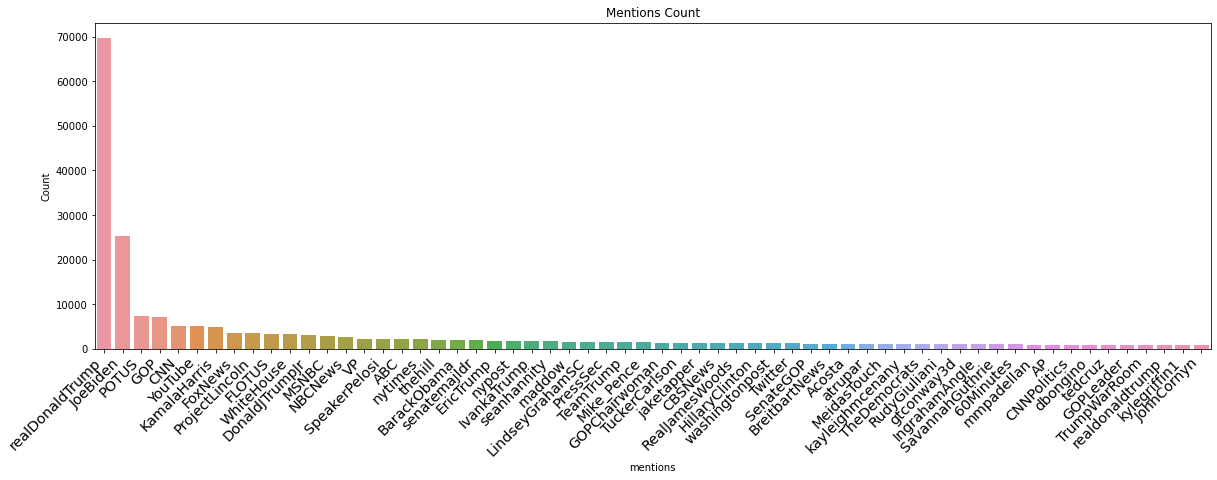

In [27]:
mention_df = get_df_plot(mention_count, 'mentions')
custom_barplot(mention_df, top=60, x_label='mentions')

#### Users

In [28]:
users_df = tweets_df[['user_name', 'id']].groupby(['user_name']).count()
users_df.sort_values(by=['id'], ascending=False, inplace=True)

In [29]:
users_df.head(100)

,id
user_name,
TheCupofJoeintheD,1959
Global News Report,1720
Hotpage News,1310
Revue2presse,1205
PulpNews Crime,1094
All Express News,1075
Athena_Speaks,1072
t Logan,1059
Scott McLeod,968


#### N-Grams

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
# nltk.download()

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [31]:
camelCaseRegex = re.compile(r"[a-zA-Z\d](?:[a-z\d']+|[A-Z\d']*(?=[A-Z\d']|$))")
punctuation_regex = re.compile(r"([^\w'\s])")
url_regex = re.compile(r'(www|http)\S+')

def camel_case_split(identifier):
    matches = camelCaseRegex.finditer(identifier)    
    return " ".join([m.group(0) for m in matches])

#-------------------------------------------------#
def clean(text):
    if not isinstance(text, str):
        return ''

    #-------------------------------------------------#
    text = url_regex.sub('', text) #remove link    
    text = emoji.demojize(text)
    text = punctuation_regex.sub(' ', text)
    text = " ".join([camel_case_split(token).lower() for token in text.split()])    
    return text

In [33]:
def get_top_ngrams(corpus, n=2, topN=10, useTfidf=True):
    """ return top N word/bigram in the corpus by count/tfidf
    """
    if useTfidf:
        vec = TfidfVectorizer(ngram_range=(1, n), stop_words=STOPWORDS).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(1, n), stop_words=STOPWORDS).fit(corpus)

    bow = vec.transform(corpus)
    s = bow.sum(axis=0)

    Y = []
    for n in range(n):
        ngramFreq = [(ngram, s[0, idx]) for ngram, idx in vec.vocabulary_.items()
                      if len(ngram.split(' '))==n+1]
        ngramFreq = sorted(ngramFreq, key = lambda x: x[1], reverse=True)
        Y.append(ngramFreq[:topN])

    return Y

In [34]:
def ngram_plots(df, topN=20, useTfidf=True):

    ngram_1g, ngram_2g = get_top_ngrams(df, 2, topN, useTfidf=useTfidf)
    pos    = [211, 212]
    ngrams = [ngram_1g, ngram_2g]
    titleWords = ['word', 'bigram']

    #-------------------------------------------------------#
    f = plt.figure(figsize=(15, topN))
    axes = []            
    for i in range(len(ngrams)):
        axes.append(f.add_subplot(pos[i]))
        x, y = map(list, zip(*ngrams[i]))
        sns.barplot(x=y,y=x, ax=axes[i], palette='deep')
        axes[i].set_title(f'Top {topN} {titleWords[i]} counts')

In [35]:
%%time
pandarallel.initialize()

tweets_df['clean text'] = tweets_df['text'].parallel_apply(lambda x: clean(x))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 589 ms, sys: 633 ms, total: 1.22 s
Wall time: 2min 29s


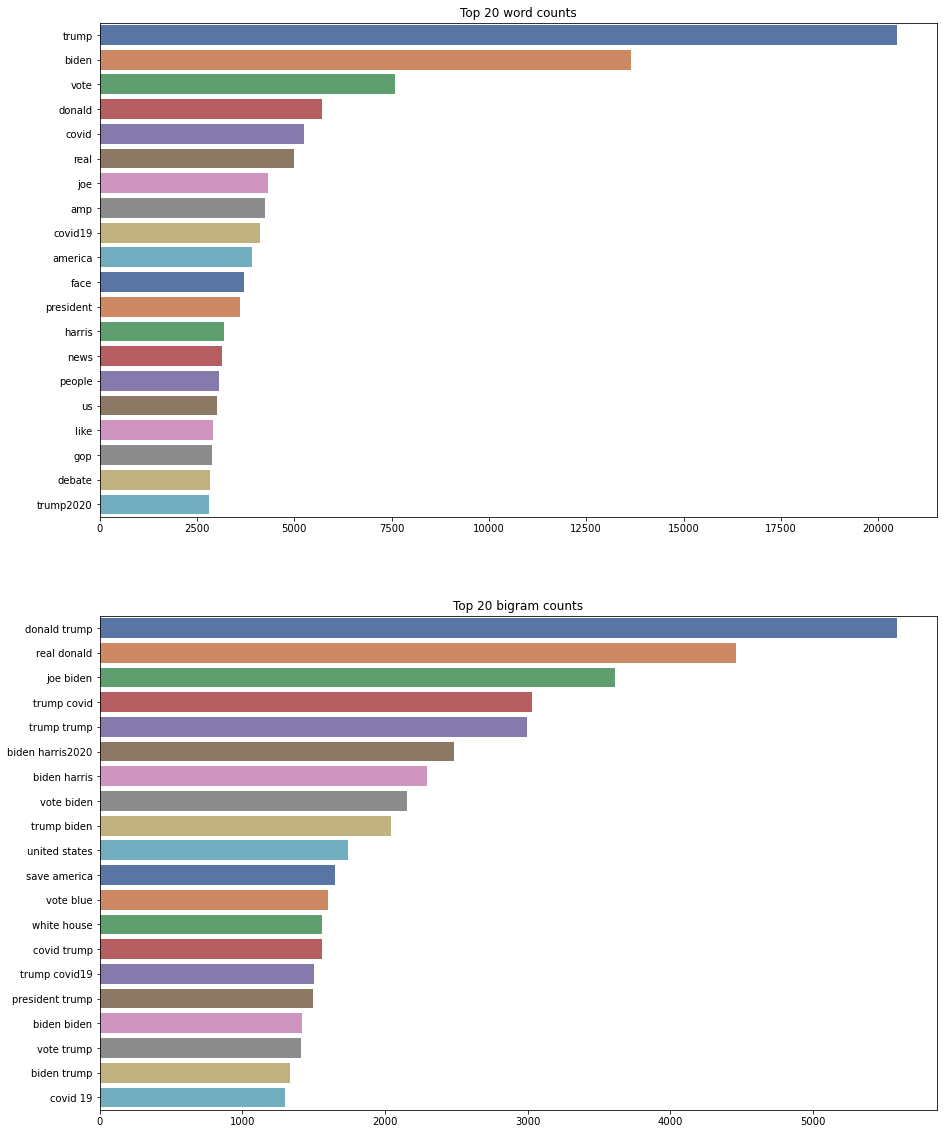

In [36]:
ngram_plots(tweets_df['clean text'])

#### Token count in user_name and user_description

In [37]:
len(tweets_df.user_name.unique())

147664

In [38]:
len(tweets_df)

621404

In [39]:
regex = re.compile('\W')
url_regex = re.compile(r'(www|http)\S+')
        
def tokenize(text):
    if isinstance(text, str):
        text = url_regex.sub('', text) #remove link    
        text = emoji.demojize(text)
        return ' '.join([token for token in regex.split(text) if len(token)>0])
    else:
        return ''

In [40]:
%%time
pandarallel.initialize()
tweets_df['user_name'] = tweets_df['user_name'].parallel_apply(lambda x: tokenize(x))
tweets_df['user_description'] = tweets_df['user_description'].parallel_apply(lambda x: tokenize(x))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 753 ms, sys: 788 ms, total: 1.54 s
Wall time: 1min 38s


CPU times: user 16.1 s, sys: 75.4 ms, total: 16.2 s
Wall time: 16.2 s


/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32599 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 32599 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ivan/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20234 missing from current font.
  font.set_text(s, 0, flags=flags)


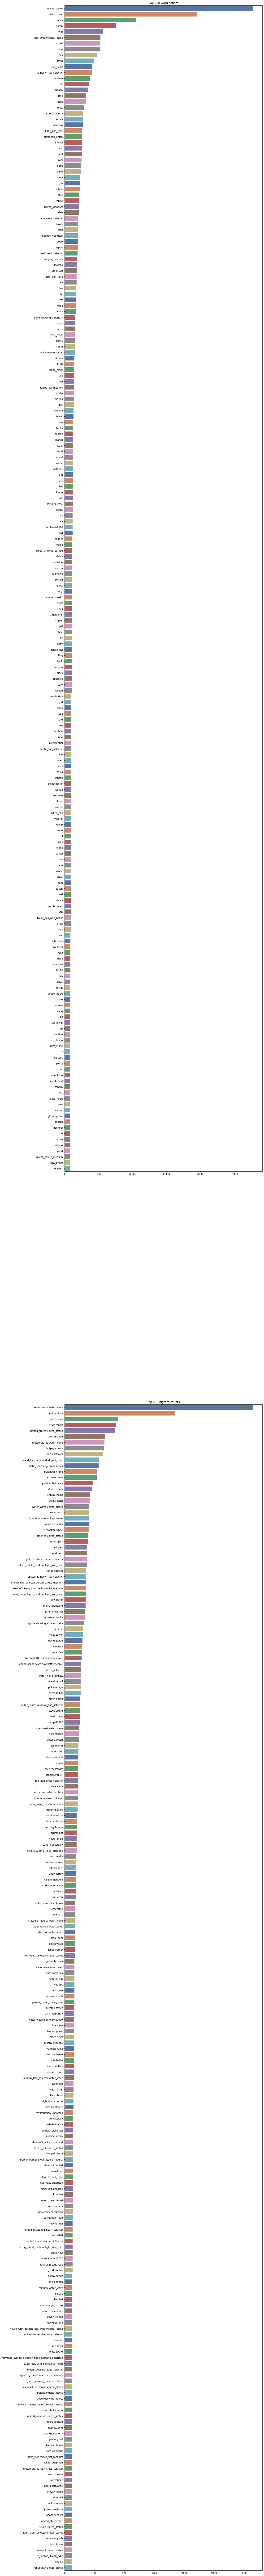

In [41]:
%%time
ngram_plots(tweets_df['user_name'], topN=200, useTfidf=False)

CPU times: user 48.5 s, sys: 507 ms, total: 49 s
Wall time: 49 s


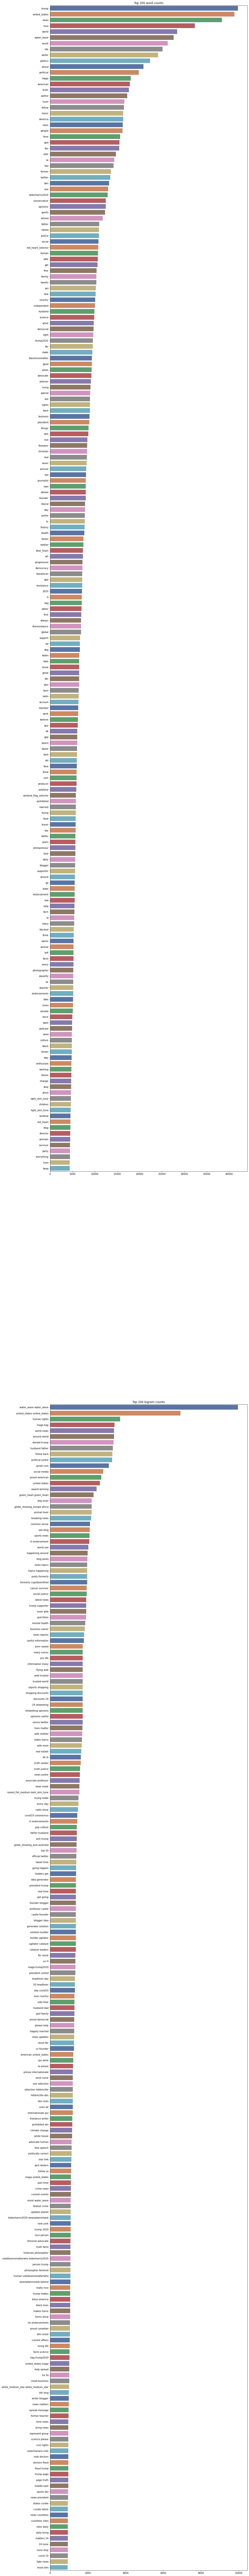

In [42]:
%%time
ngram_plots(tweets_df['user_description'], topN=200, useTfidf=False)